In [24]:
from src.experiment import ExperimentFramework
from src.viz import Visualizer

# define data directory
data_dir = 'data/daily_cluster_matrices_min_6'

# initialize experiment 
experiment = ExperimentFramework(data_dir)

# run experiment
n_samples = 10
n_days = 120


experiment_summary = experiment.run_experiment(n_samples=n_samples, n_days=n_days)
print(f"\n{experiment_summary['total_results']} results")

# initialize visualizer
analyzer = experiment.analyzer
# analyzer.exclude_results(min_communities=2, max_communities=10)
viz = Visualizer(analyzer)

initializing media bias experiment...
loading 241 daily matrices...
loaded 241 datasets
241 daily files loaded

=== starting experiment: 10 samples x 120 days ===

running sample: sample_00
created sample 'sample_00' with 120 days, shape: (49, 34553)
set data: 49 entities, 34553 clusters
built cooccurrence adjacency: (49, 49)
built jaccard adjacency: (49, 49)
built dice adjacency: (49, 49)
built cosine adjacency: (49, 49)
built correlation adjacency: (49, 49)
built pmi adjacency: (49, 49)
built lift adjacency: (49, 49)
built tfidf_similarity adjacency: (49, 49)
built conditional_probability adjacency: (49, 49)

processing cooccurrence adjacency matrix...
louvain params_0: 4 communities
louvain params_1: 5 communities
louvain params_2: 5 communities
louvain params_3: 2 communities
louvain params_4: 3 communities
louvain params_5: 5 communities
louvain params_6: 11 communities
louvain params_7: 22 communities
louvain params_8: 27 communities
leiden params_0: 2 communities
leiden params_1

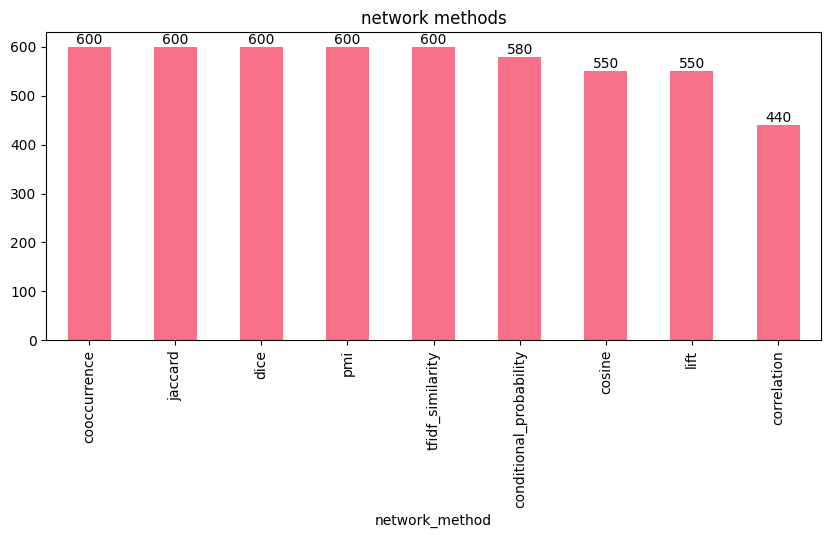

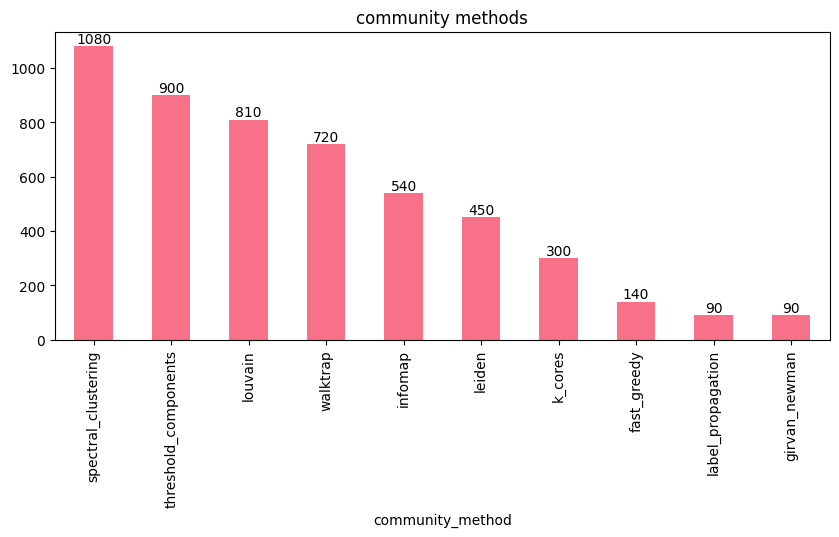

In [25]:
import matplotlib.pyplot as plt
df = analyzer.get_results()
# show bar charts for all network and community methods with counts annotated

vc_net = df['network_method'].value_counts()
ax = vc_net.plot.bar(figsize=(10,4), title='network methods')
for i, v in enumerate(vc_net):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.show()

vc_comm = df['community_method'].value_counts()
ax = vc_comm.plot.bar(figsize=(10,4), title='community methods')
for i, v in enumerate(vc_comm):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.show()


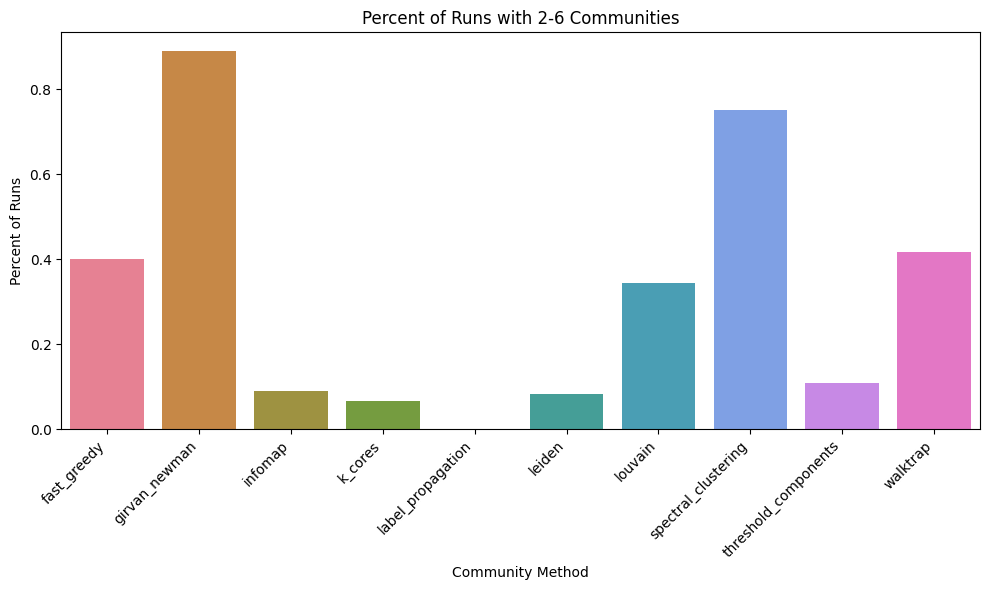

In [ ]:
import seaborn as sns
# calculate percentage of runs with 2-6 communities per method
df = analyzer.get_results()
method_stats = df.groupby('community_method').agg({
    'n_communities': lambda x: ((x >= 2) & (x <= 6)).mean()
}).reset_index()

# plot as bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=method_stats, x='community_method', y='n_communities', palette='husl')

plt.title('Percent of Runs with 2-6 Communities')
plt.xlabel('Community Method')
plt.ylabel('Percent of Runs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




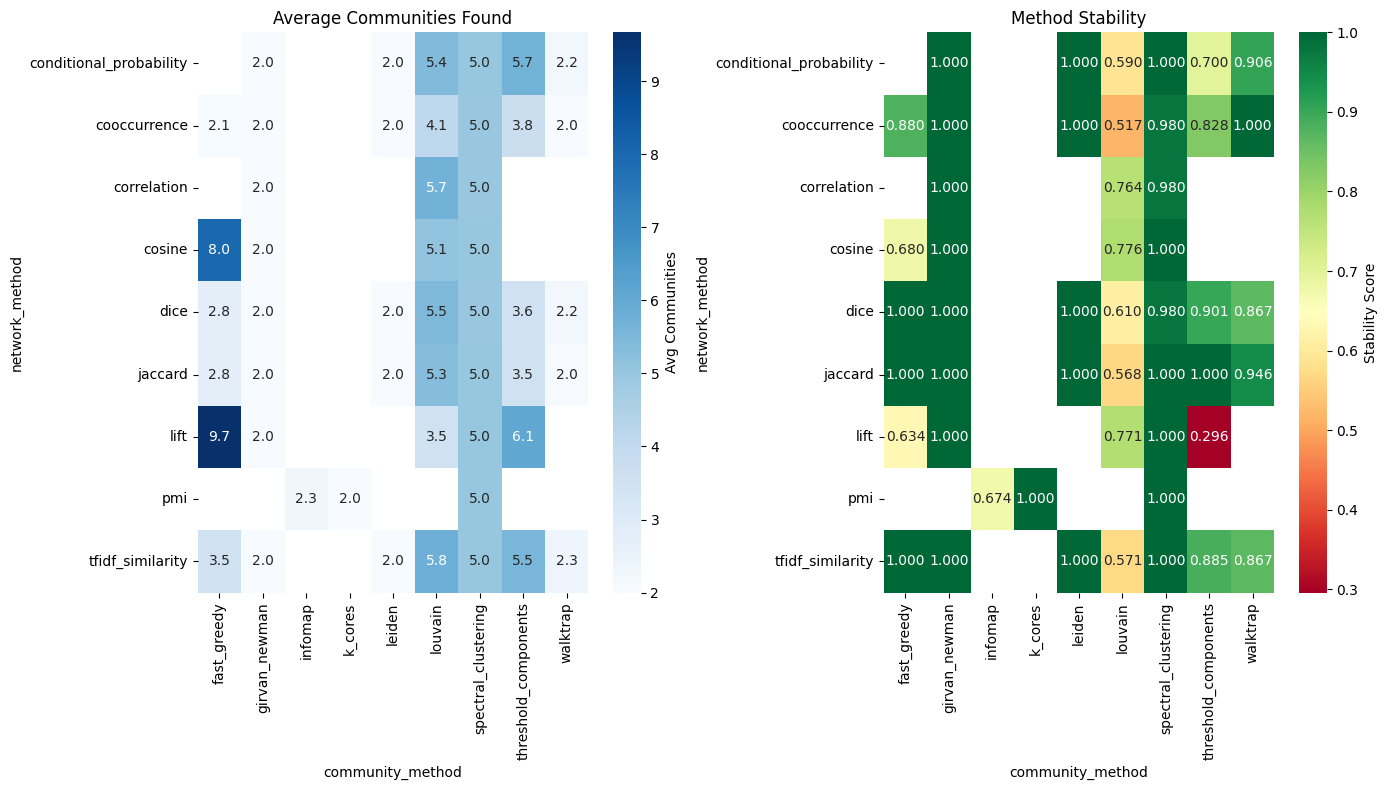

In [19]:
# # method stability
# viz.plot_stability_ranking(top_n=15) # extremely uninformative
viz.plot_method_comparison()


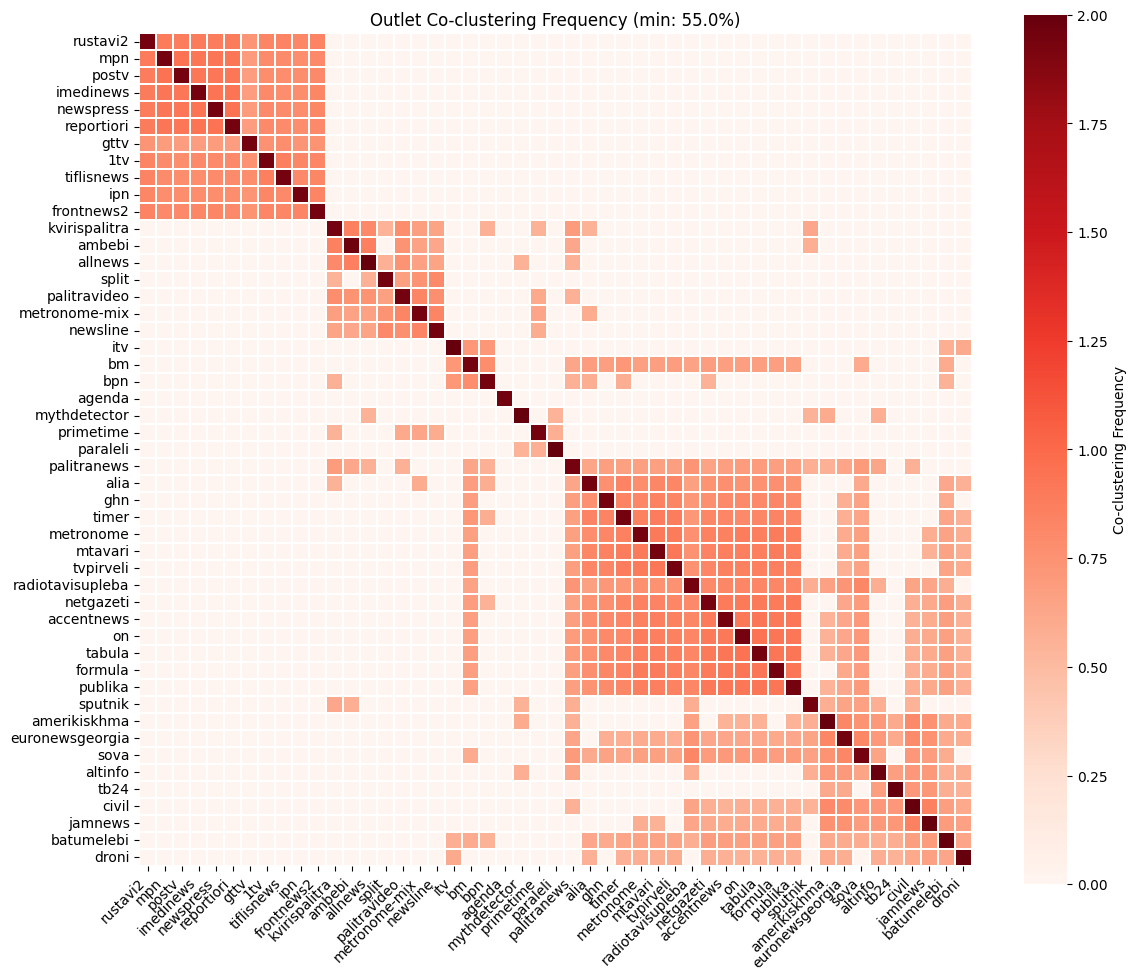


Outlet Co-clustering Analysis:
• Outlets analyzed: 49
• Pairs above 55.0% threshold: 328
• Mean frequency: 0.720
• Max frequency: 0.942


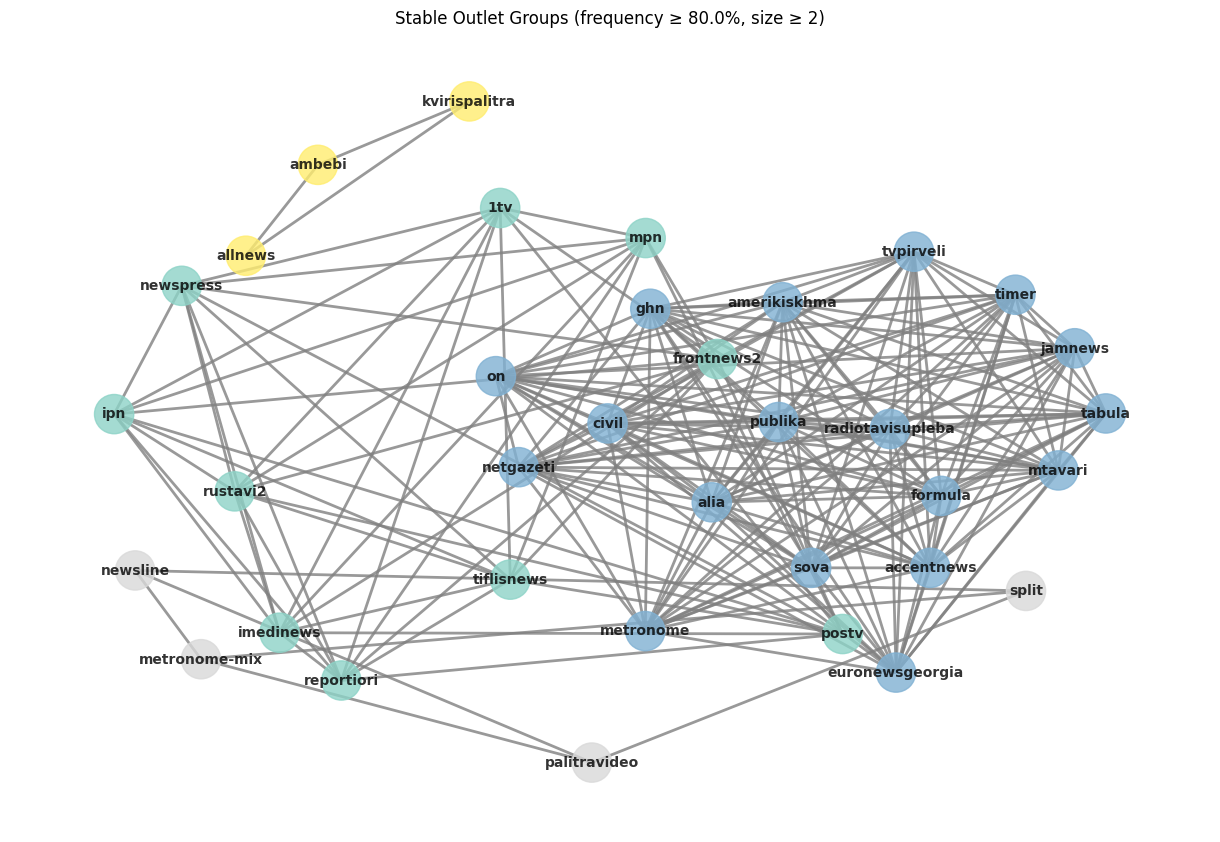


Stable Outlet Groups Found (4):
--------------------------------------------------
1. stable_group_1: 10 outlets
   Members: 1tv, frontnews2, imedinews, ipn, mpn, newspress, postv, reportiori, rustavi2, tiflisnews

2. stable_group_2: 18 outlets
   Members: accentnews, alia, amerikiskhma, civil, euronewsgeorgia, formula, ghn, jamnews, metronome, mtavari, netgazeti, on, publika, radiotavisupleba, sova, tabula, timer, tvpirveli

3. stable_group_4: 4 outlets
   Members: metronome-mix, newsline, palitravideo, split

4. stable_group_12: 3 outlets
   Members: allnews, ambebi, kvirispalitra



In [20]:

# community structure discovery
viz.plot_outlet_cooccurrence(min_frequency=0.55)
# stable outlet groups
viz.plot_stable_outlet_groups(frequency_threshold=0.8, min_group_size=2)


In [4]:
# cross-method agreement
samples = experiment.data.list_samples()
if samples:
    sample_id = samples[0]
    sample_results = experiment.analyzer.get_results({'sample_id': sample_id})
    network_methods = sample_results['network_method'].unique()
    print(f"\nanalyzing method agreement for {sample_id}...")
    for network_method in network_methods[:2]:
        print(f"\nmethod similarity for {network_method}:")
        viz.plot_method_similarity(sample_id, network_method)



analyzing method agreement for sample_00...

method similarity for cooccurrence:


KeyboardInterrupt: 

In [21]:

# summary
stability = experiment.analyzer.analyze_stability()
if not stability.empty:
    best_method = stability.iloc[0]
    print(f"most stable method: {best_method['network_method']} + {best_method['community_method']}")
    print(f"stability score: {best_method['stability_score']:.3f}")
    print(f"average communities: {best_method['mean']:.1f} ± {best_method['std']:.1f}")

stable_groups = experiment.analyzer.find_stable_outlet_groups(frequency_threshold=0.7)
print(f"stable outlet groups found: {len(stable_groups)}")
if stable_groups:
    print("top groups:")
    for i, (group_name, outlets) in enumerate(list(stable_groups.items())[:3], 1):
        print(f"{i}. {group_name}: {', '.join(outlets)}")


print(f"{experiment_summary['total_results']} results analyzed")


most stable method: conditional_probability + girvan_newman
stability score: 1.000
average communities: 2.0 ± 0.0
stable outlet groups found: 3
top groups:
1. stable_group_1: 1tv, frontnews2, gttv, imedinews, ipn, mpn, newspress, postv, reportiori, rustavi2, tiflisnews
2. stable_group_2: accentnews, alia, altinfo, amerikiskhma, bm, bpn, civil, euronewsgeorgia, formula, ghn, itv, jamnews, metronome, mtavari, netgazeti, on, palitranews, publika, radiotavisupleba, sova, tabula, tb24, timer, tvpirveli
3. stable_group_3: allnews, ambebi, kvirispalitra, metronome-mix, newsline, palitravideo, split
5120 results analyzed


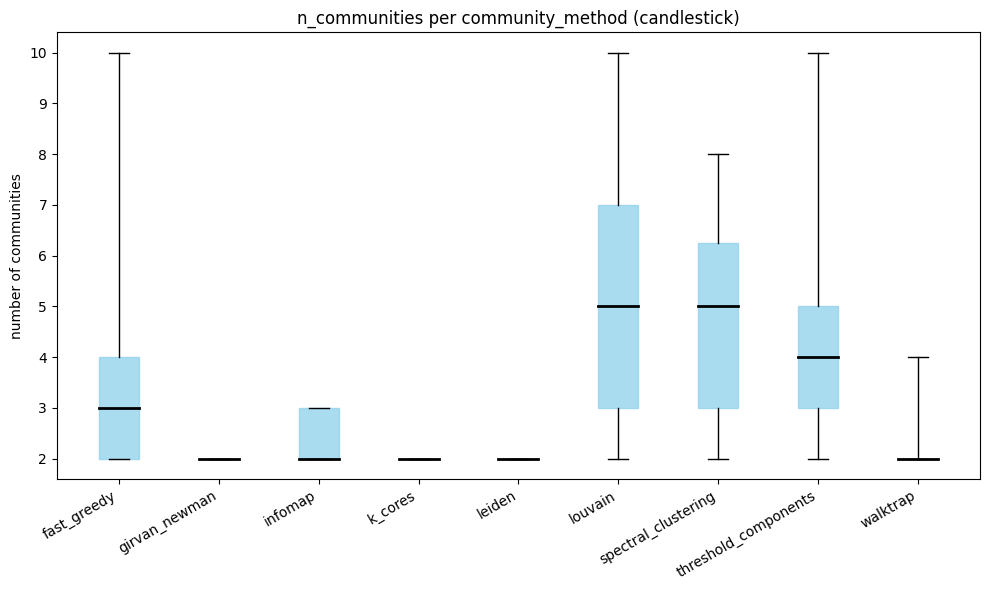

In [22]:
df = experiment.get_results_df()
import matplotlib.pyplot as plt

# compute quartiles and min/max for each community_method
stats = df.groupby('community_method')['n_communities'].agg(['min', '25%', '50%', '75%', 'max'] if '25%' in df.describe().columns else ['min', 'median', 'max', 'mean', 'std'])
if '25%' not in stats.columns:
    # fallback if percentiles are not present
    stats['25%'] = df.groupby('community_method')['n_communities'].quantile(0.25)
    stats['50%'] = df.groupby('community_method')['n_communities'].quantile(0.5)
    stats['75%'] = df.groupby('community_method')['n_communities'].quantile(0.75)
    stats['max'] = stats['max']
    stats['min'] = stats['min']

# prepare candlestick data
methods = stats.index.tolist()
candles = []
for m in methods:
    row = stats.loc[m]
    # (x, min, q1, median, q3, max)
    candles.append([methods.index(m), row['min'], row['25%'], row['50%'], row['75%'], row['max']])

fig, ax = plt.subplots(figsize=(10, 6))
for x, low, q1, med, q3, high in candles:
    # box
    ax.add_patch(plt.Rectangle((x-0.2, q1), 0.4, q3-q1, color='skyblue', alpha=0.7))
    # median line
    ax.plot([x-0.2, x+0.2], [med, med], color='k', lw=2)
    # whiskers
    ax.plot([x, x], [low, q1], color='k', lw=1)
    ax.plot([x, x], [q3, high], color='k', lw=1)
    # caps
    ax.plot([x-0.1, x+0.1], [low, low], color='k', lw=1)
    ax.plot([x-0.1, x+0.1], [high, high], color='k', lw=1)

ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, rotation=30, ha='right')
ax.set_ylabel('number of communities')
ax.set_title('n_communities per community_method (candlestick)')
plt.tight_layout()
plt.show()


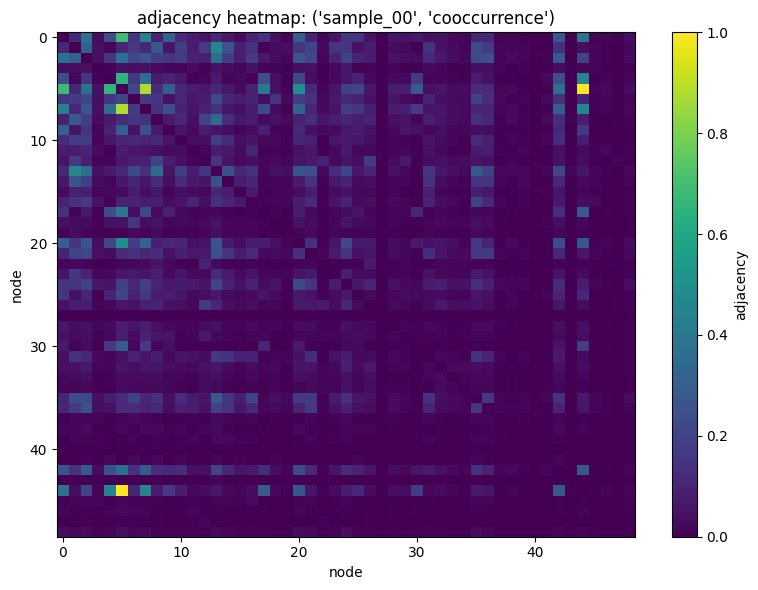

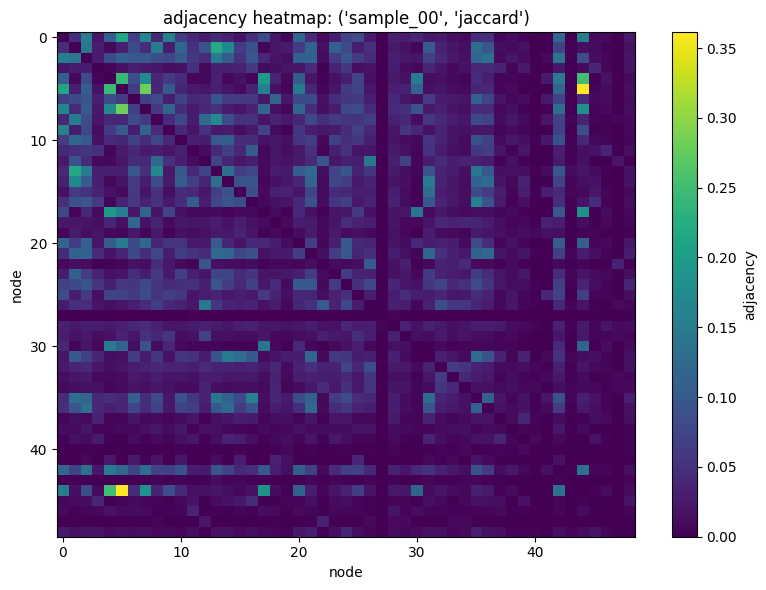

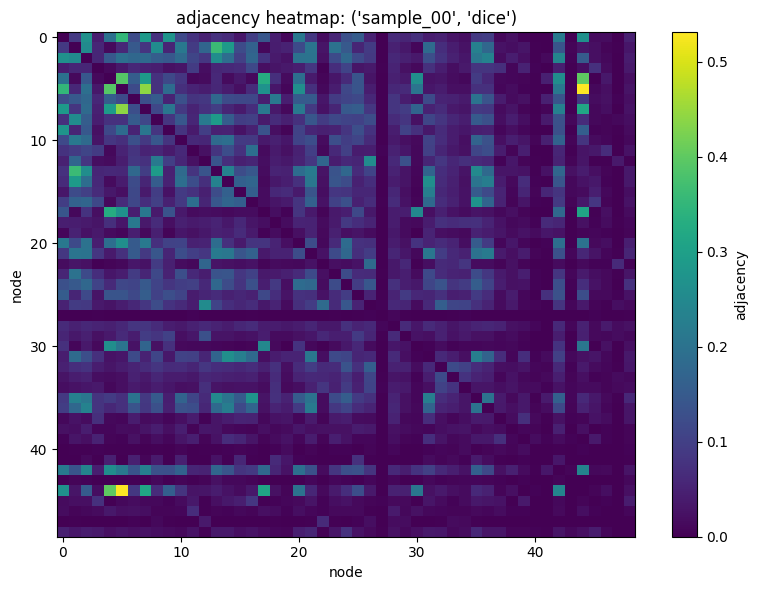

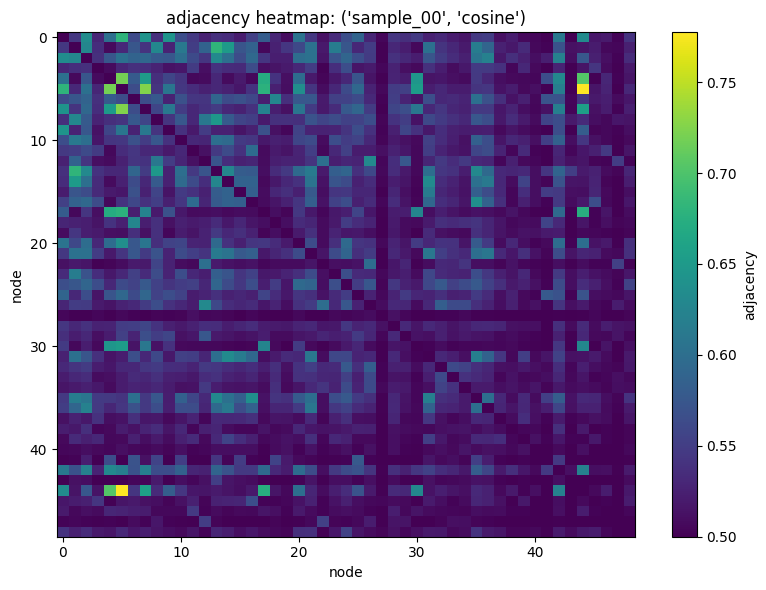

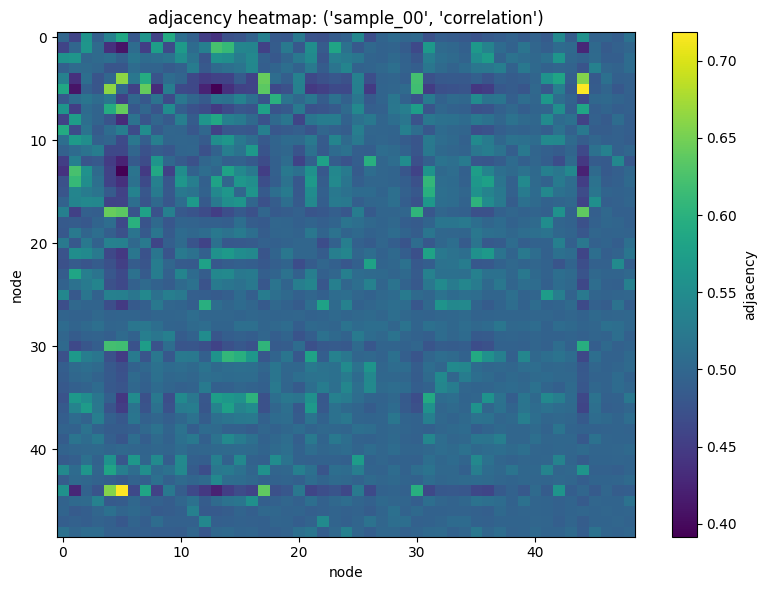

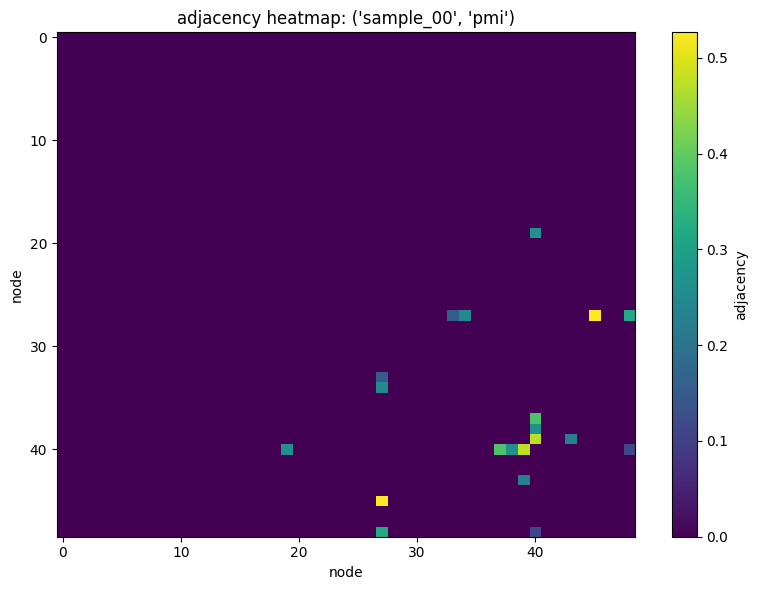

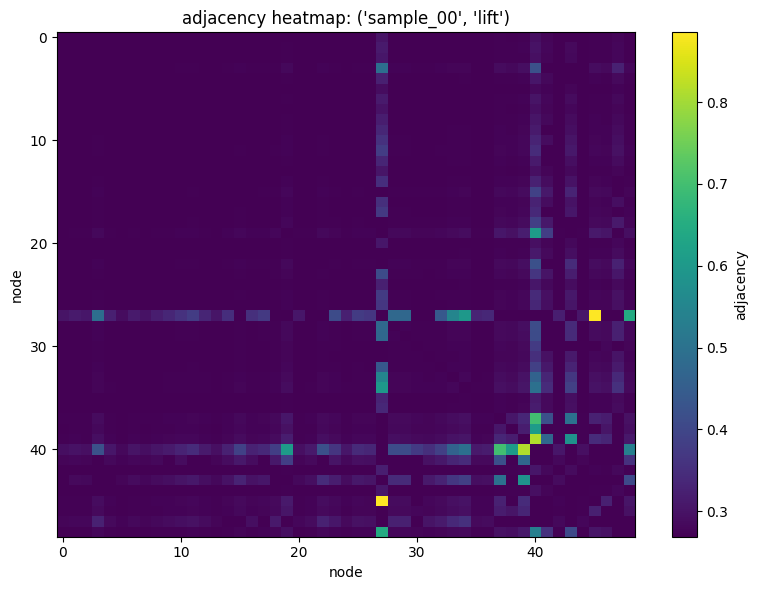

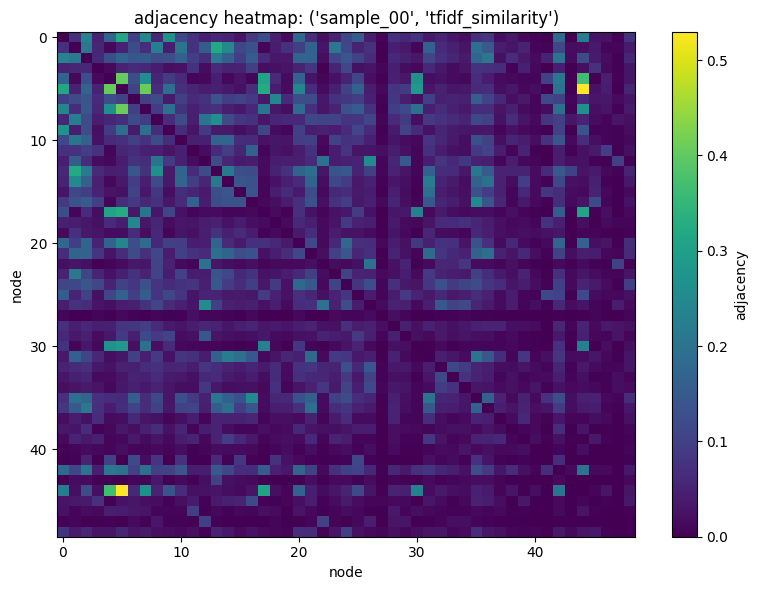

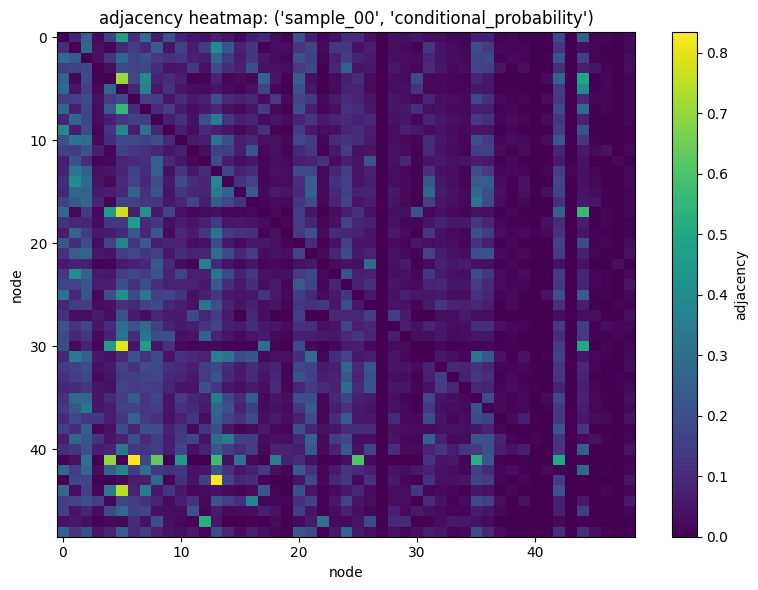

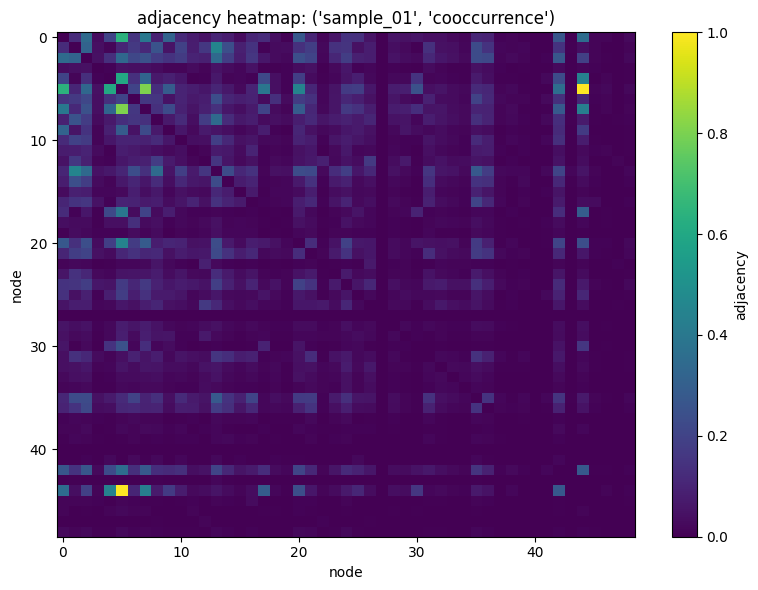

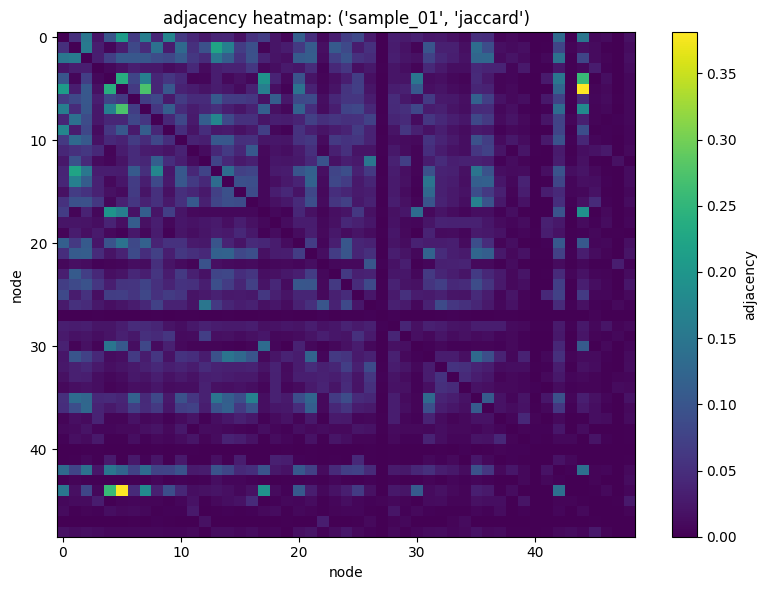

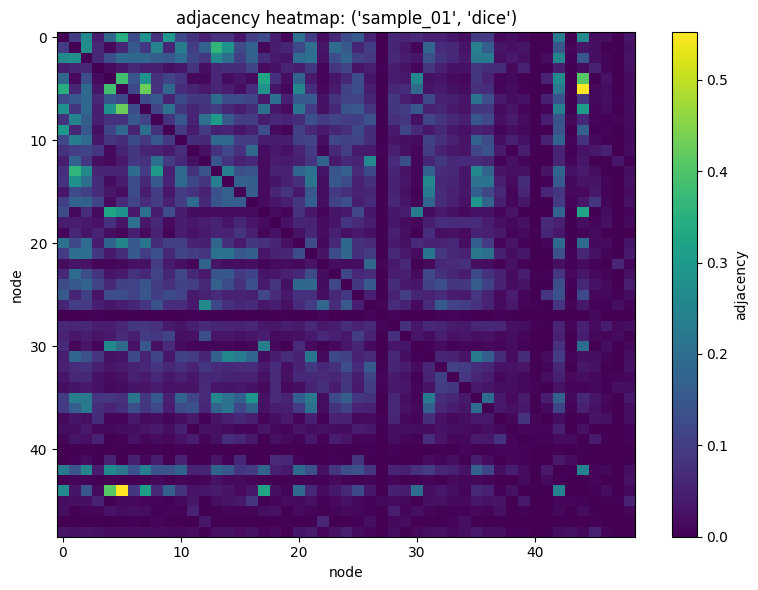

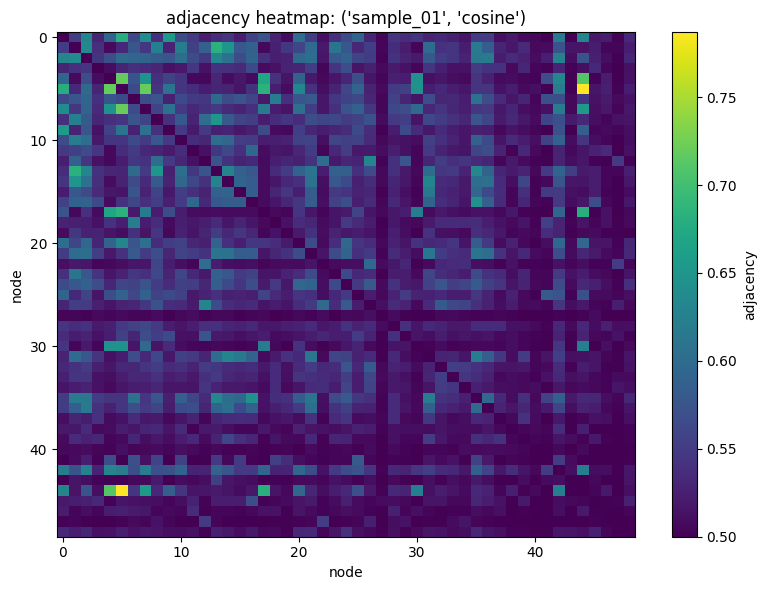

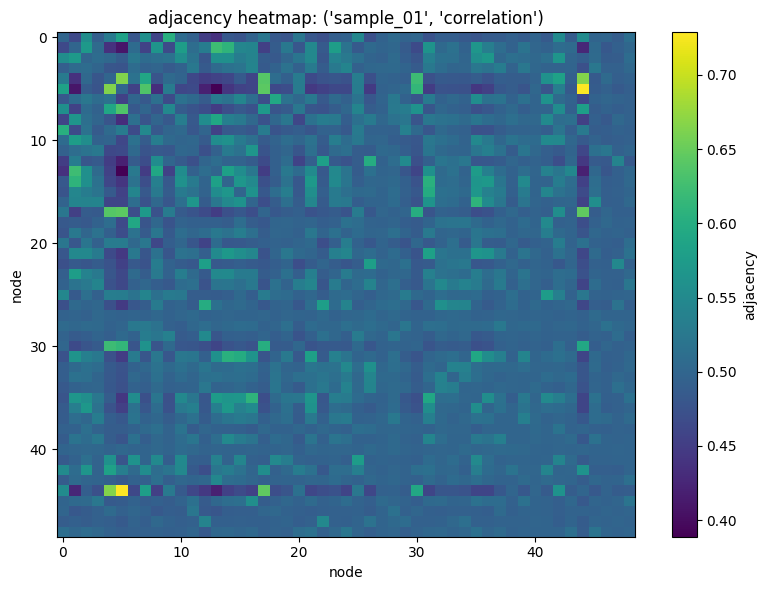

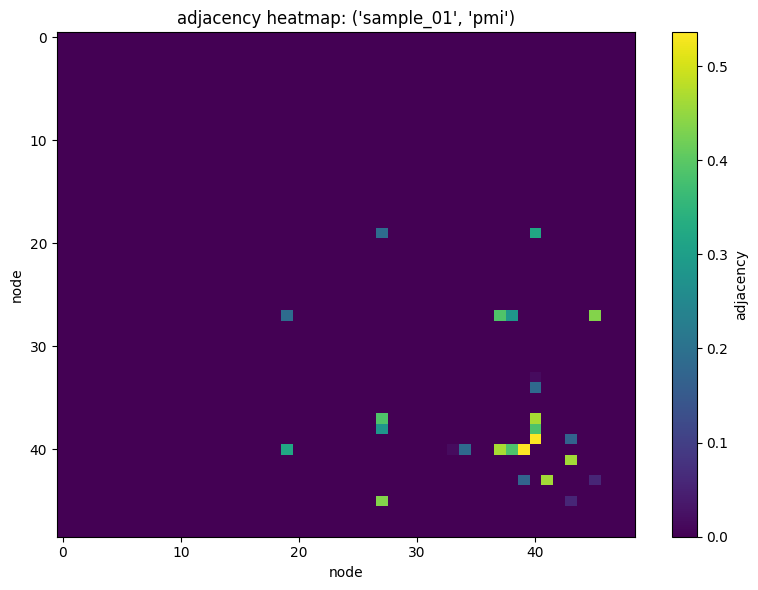

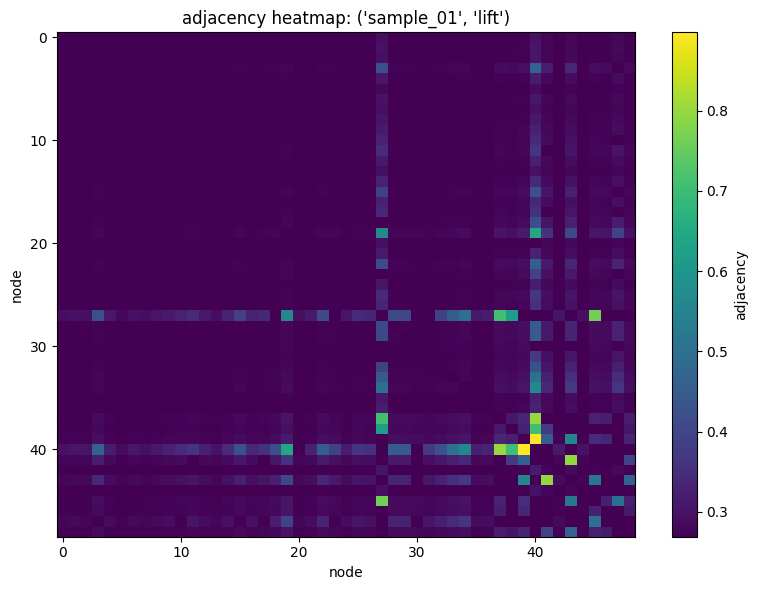

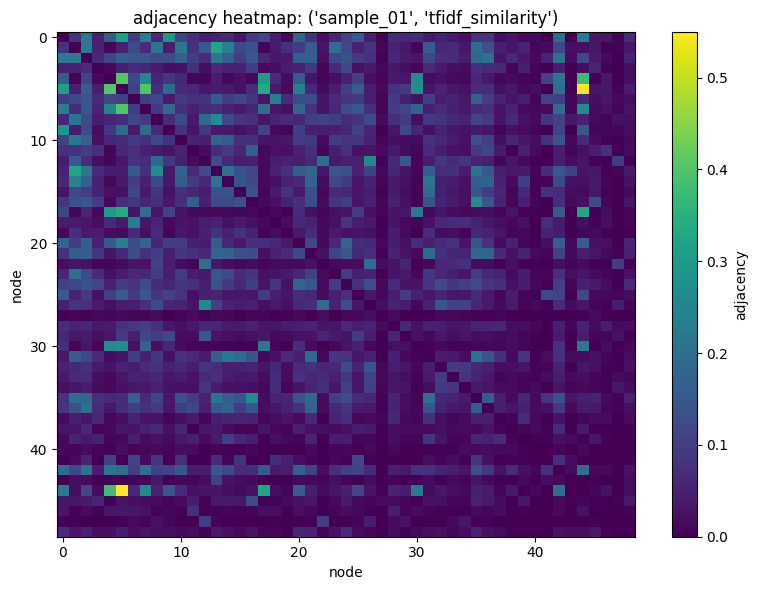

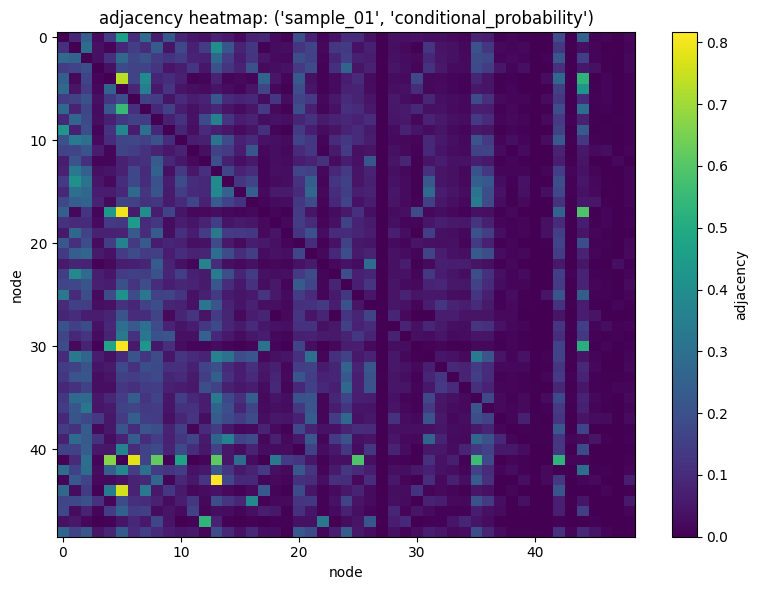

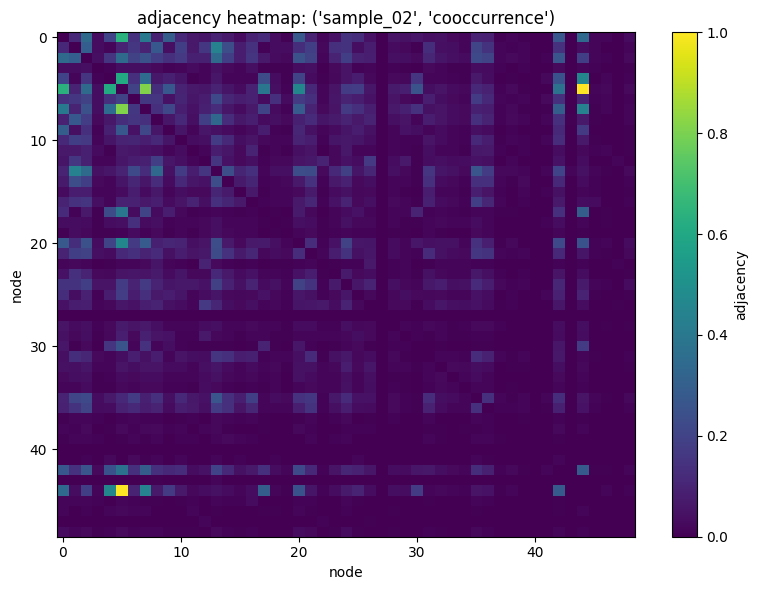

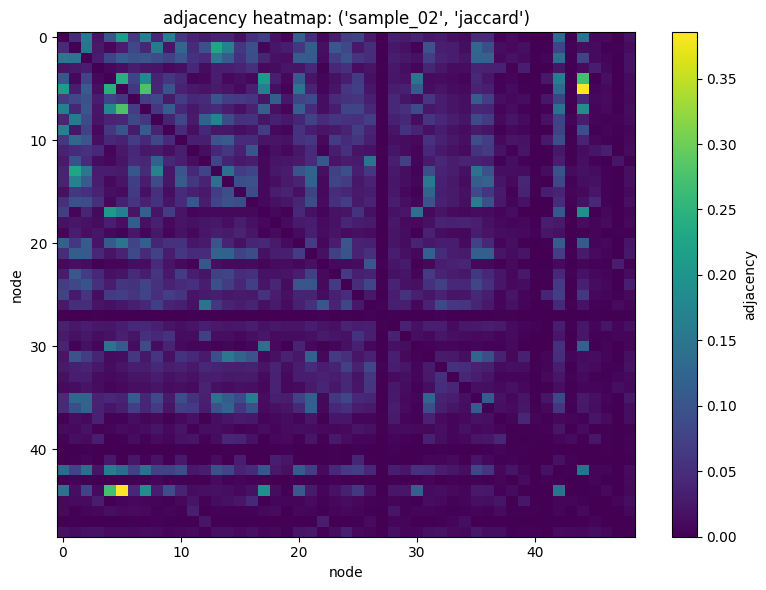

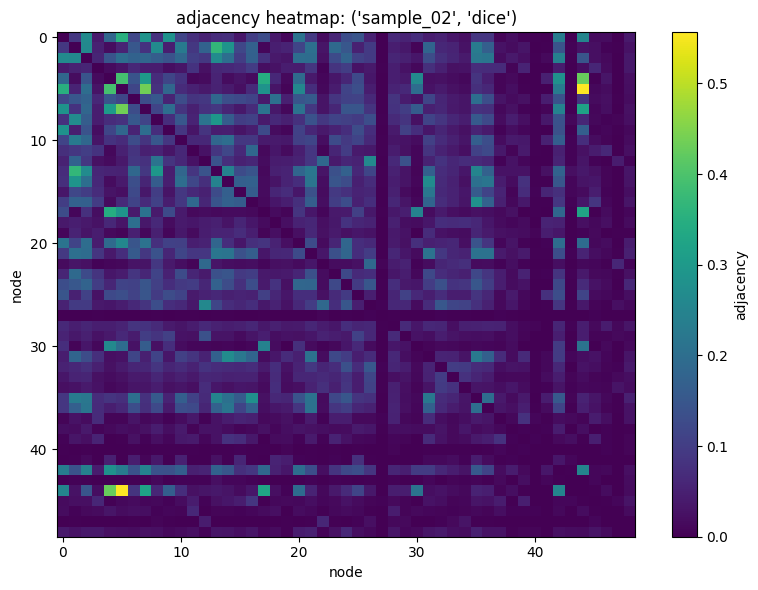

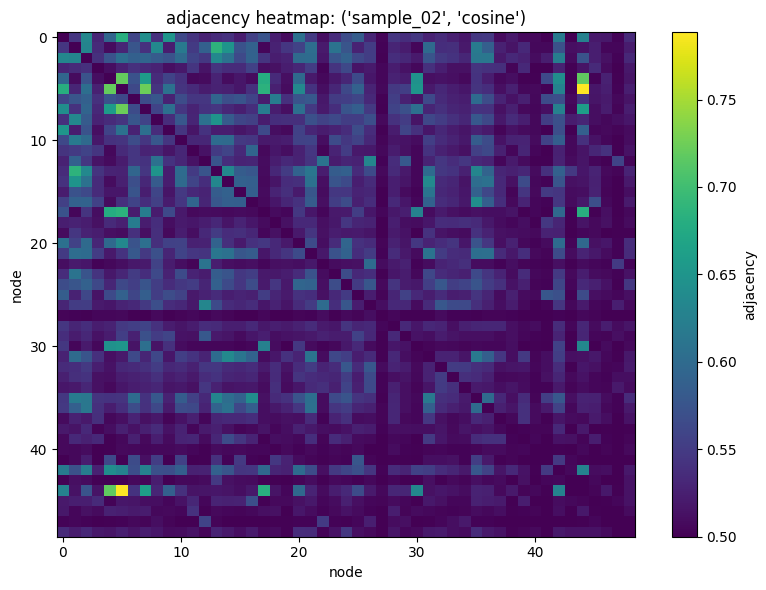

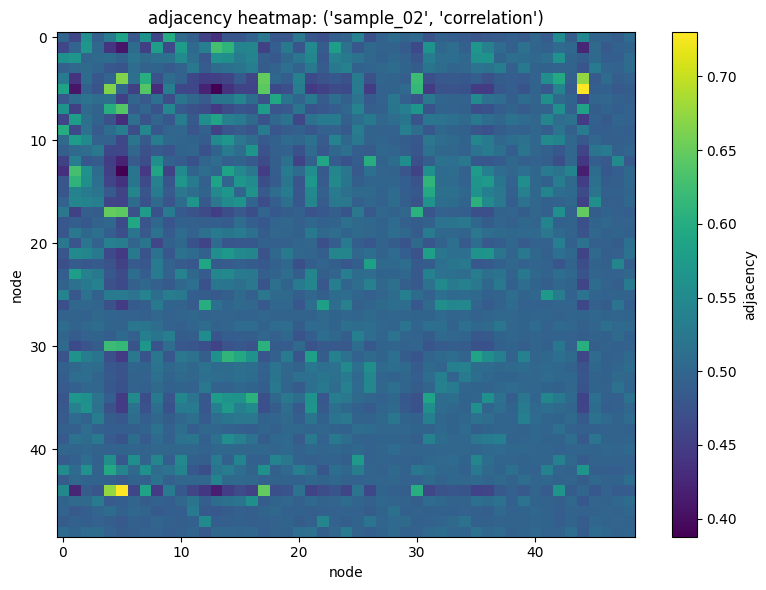

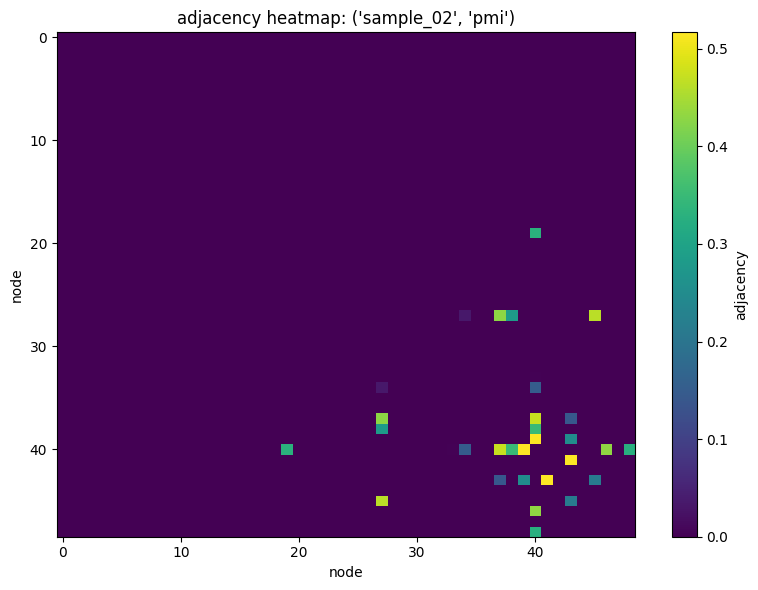

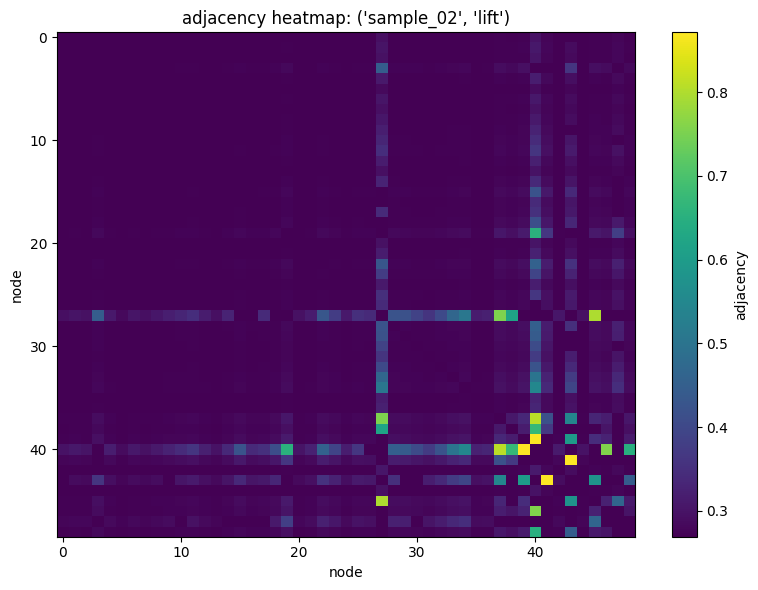

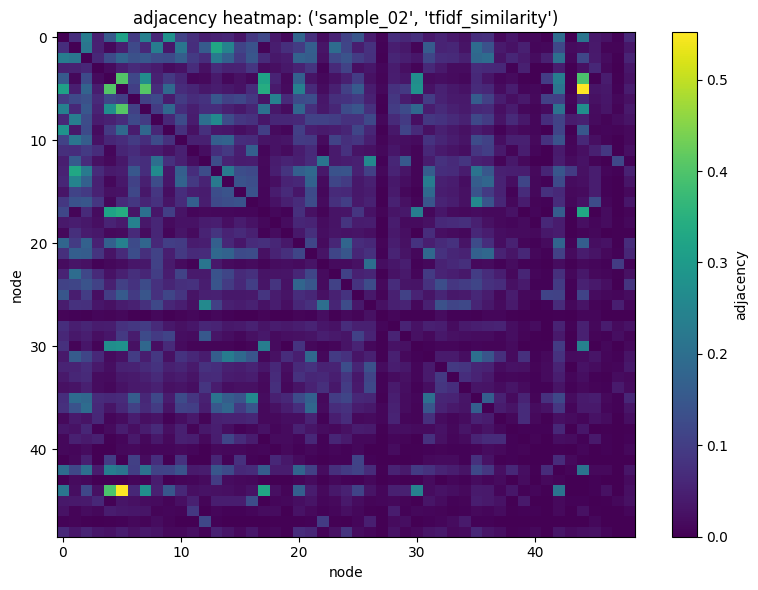

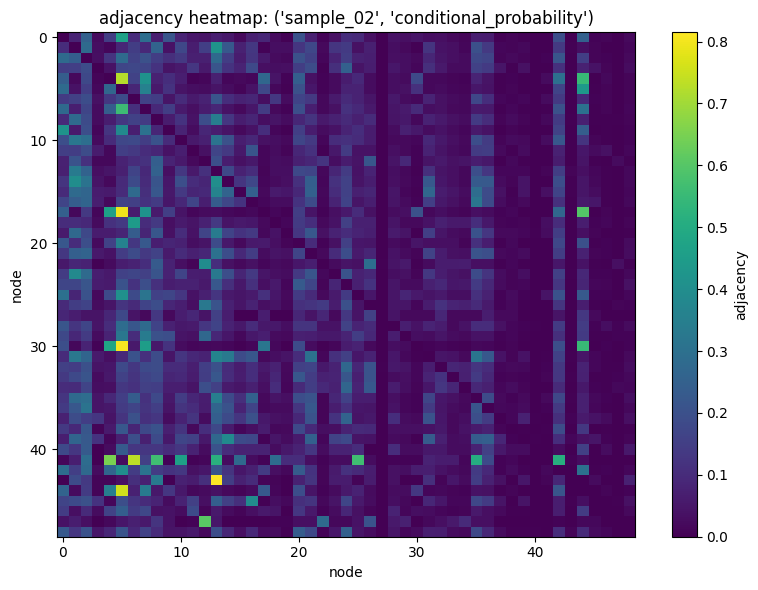

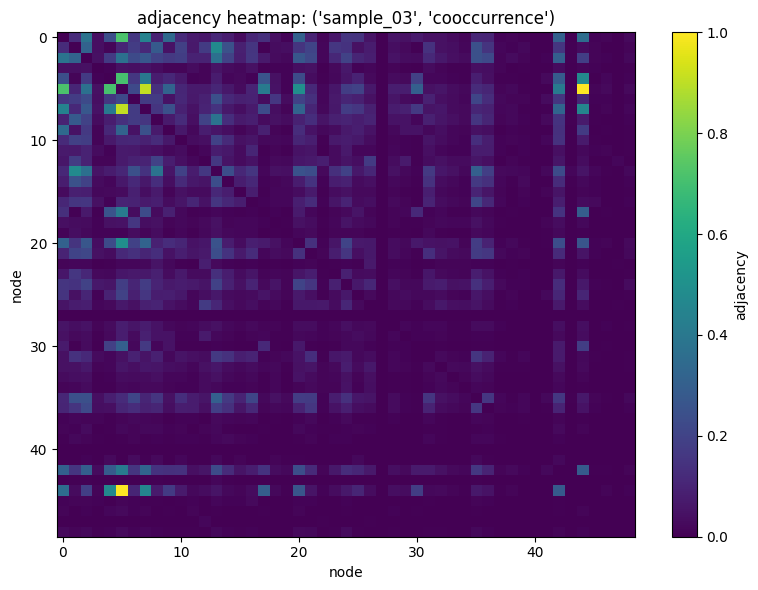

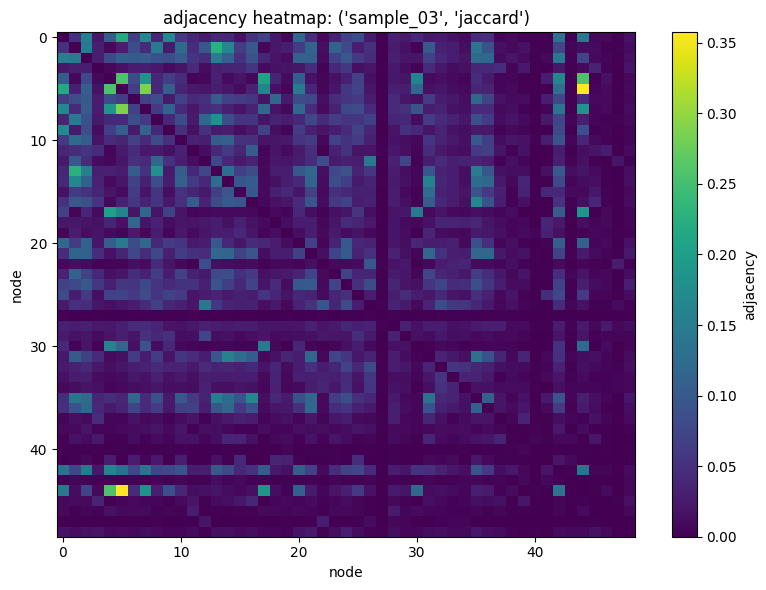

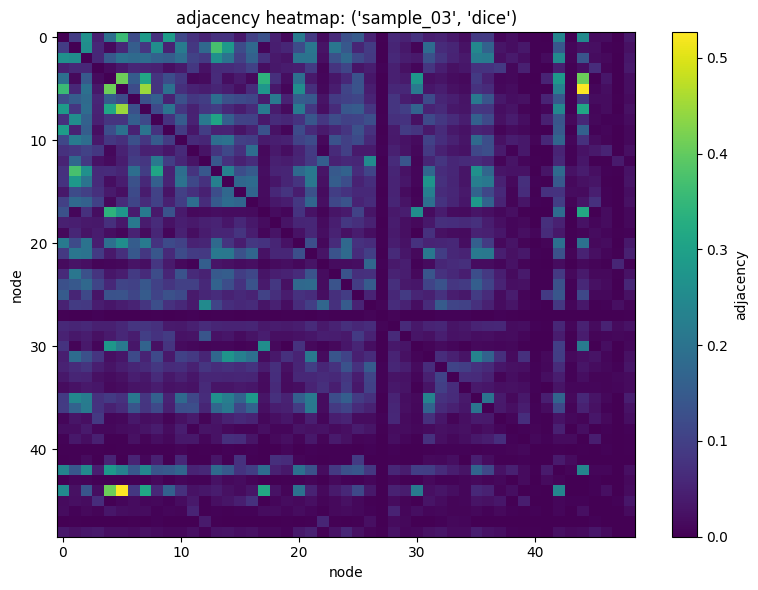

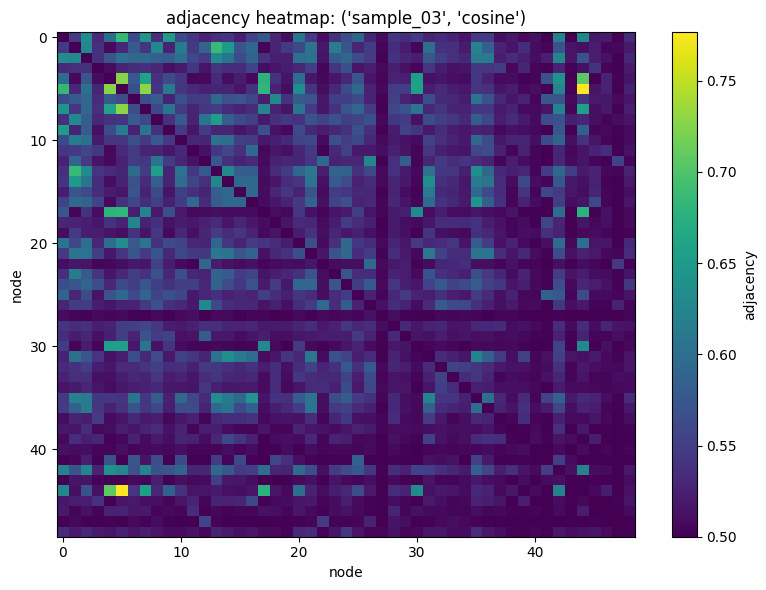

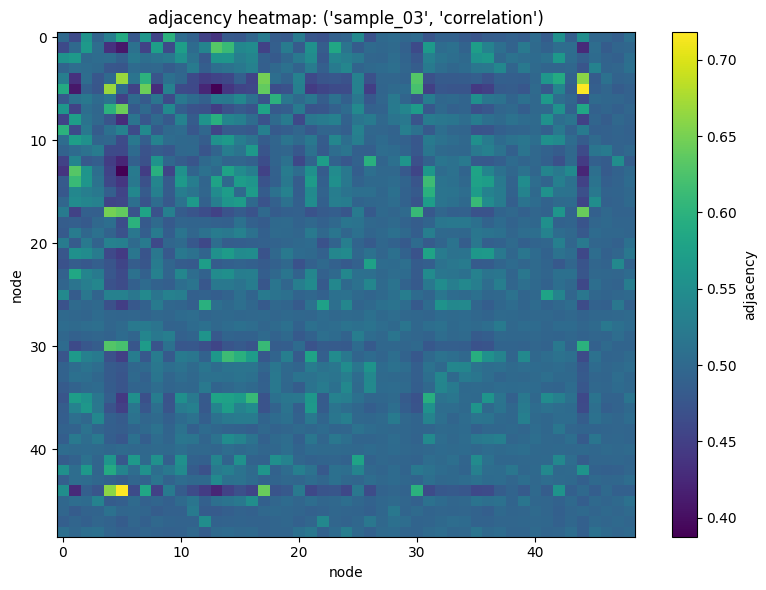

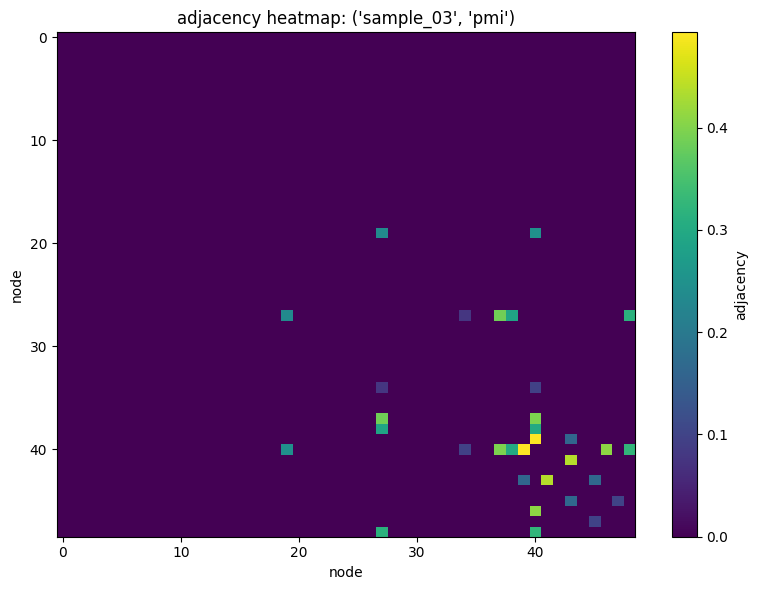

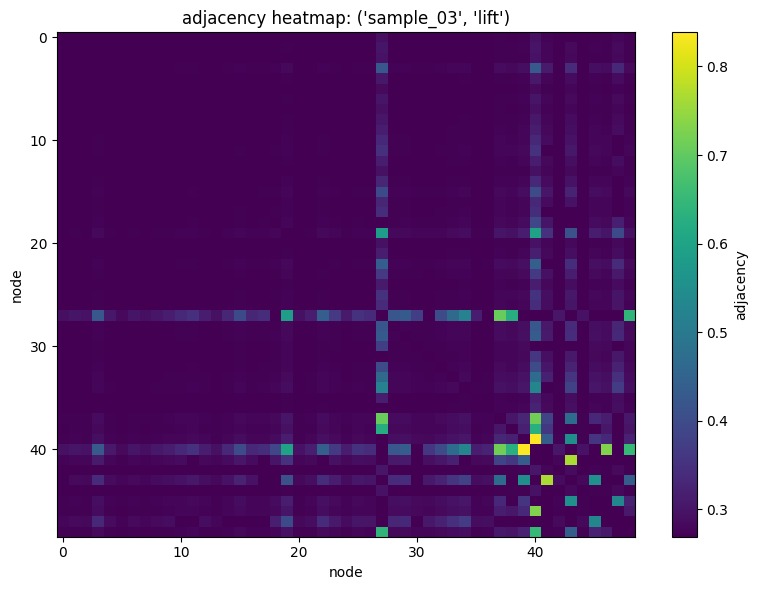

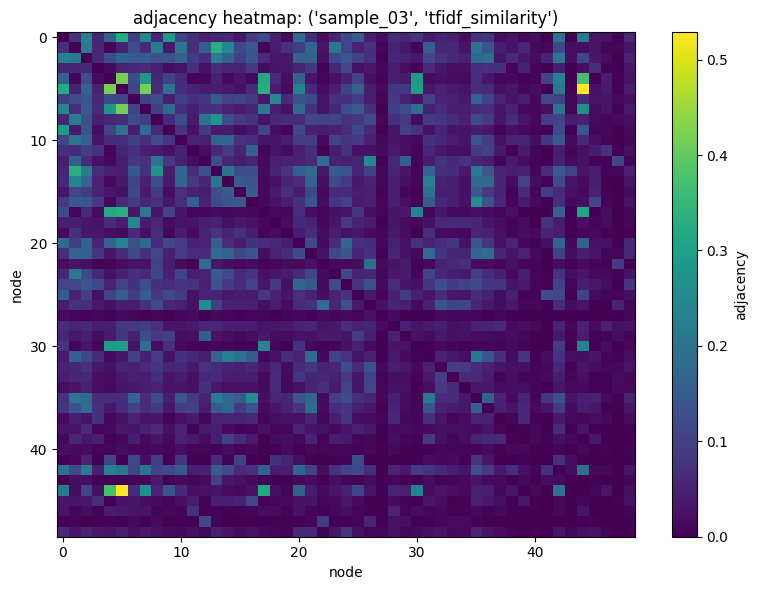

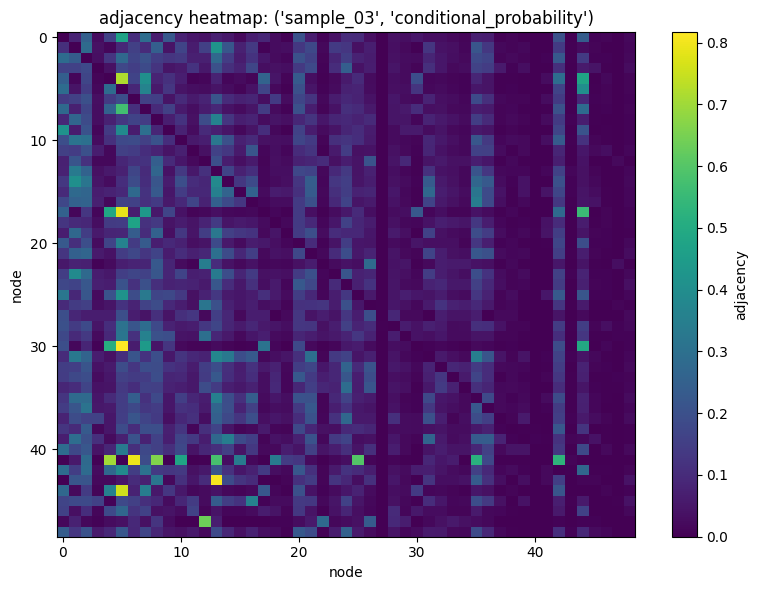

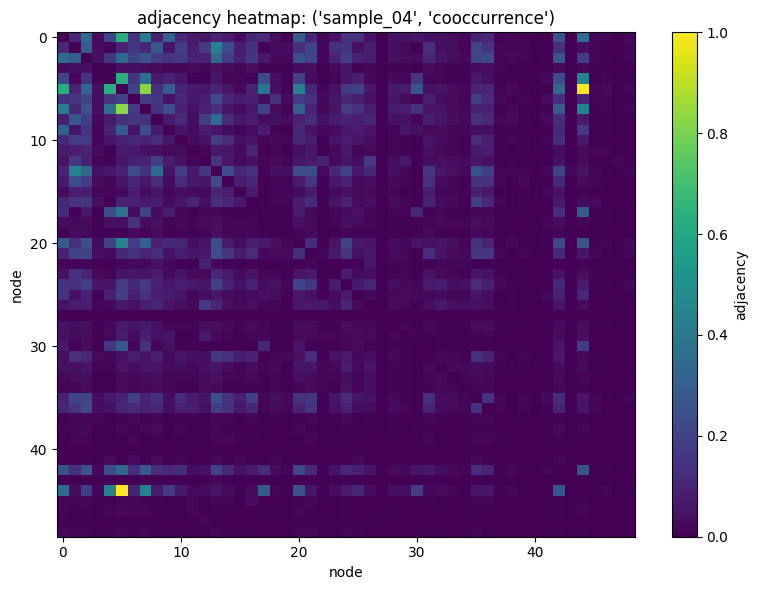

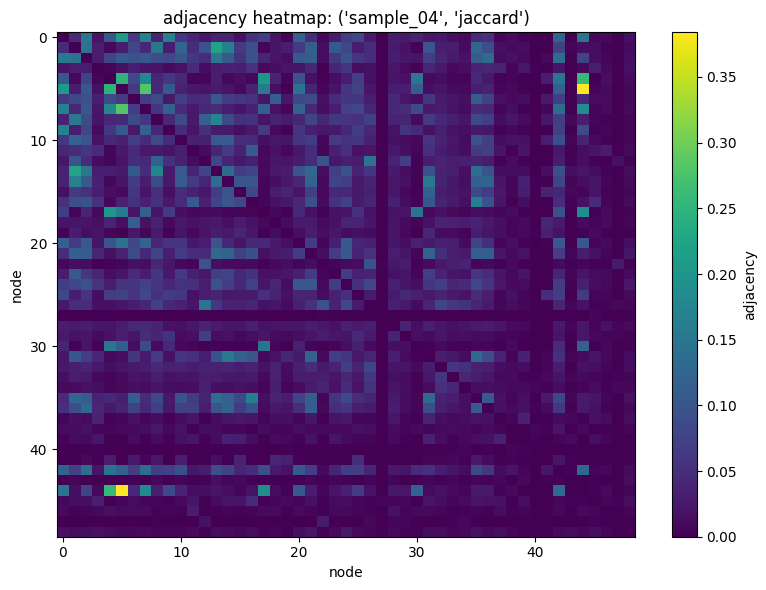

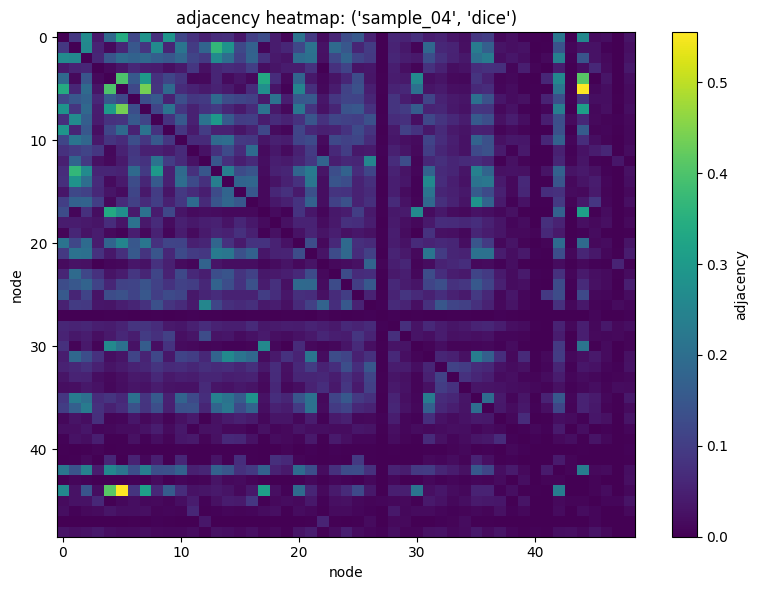

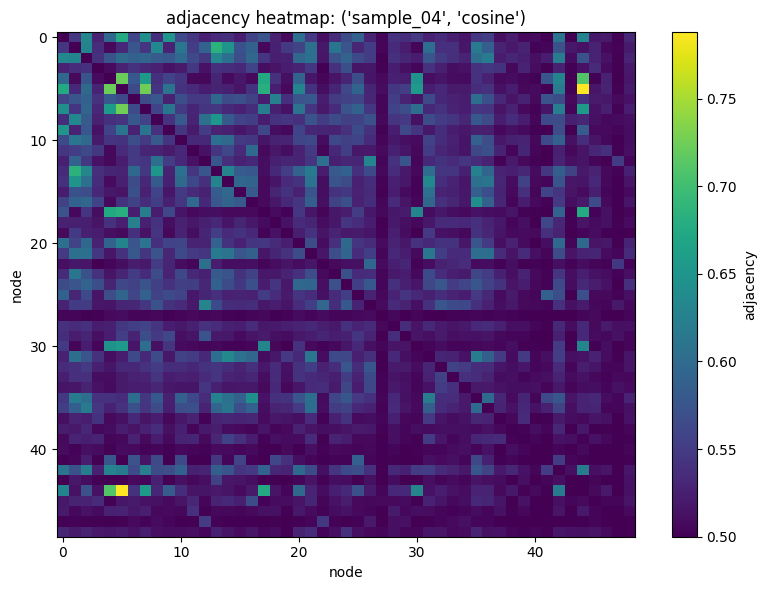

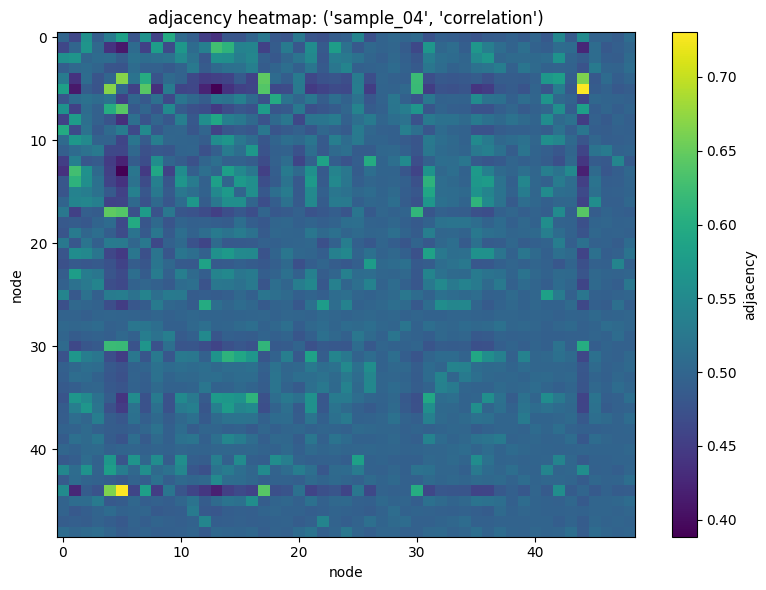

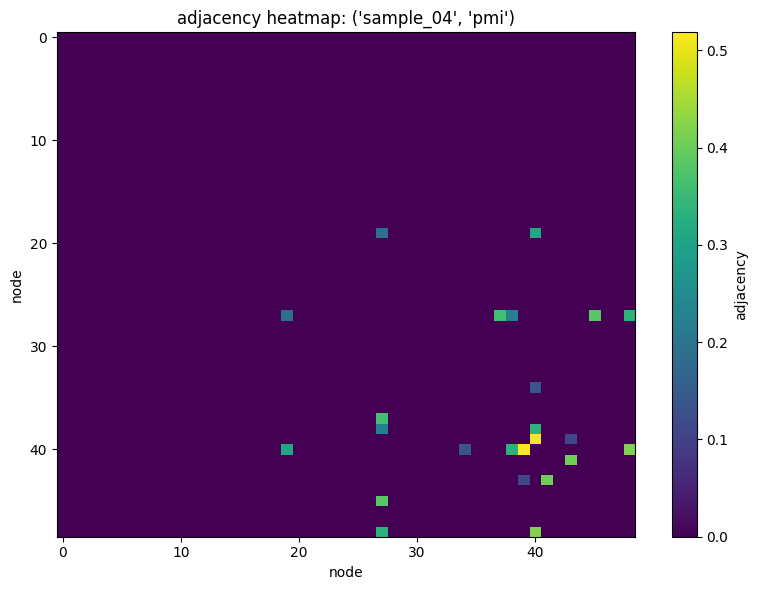

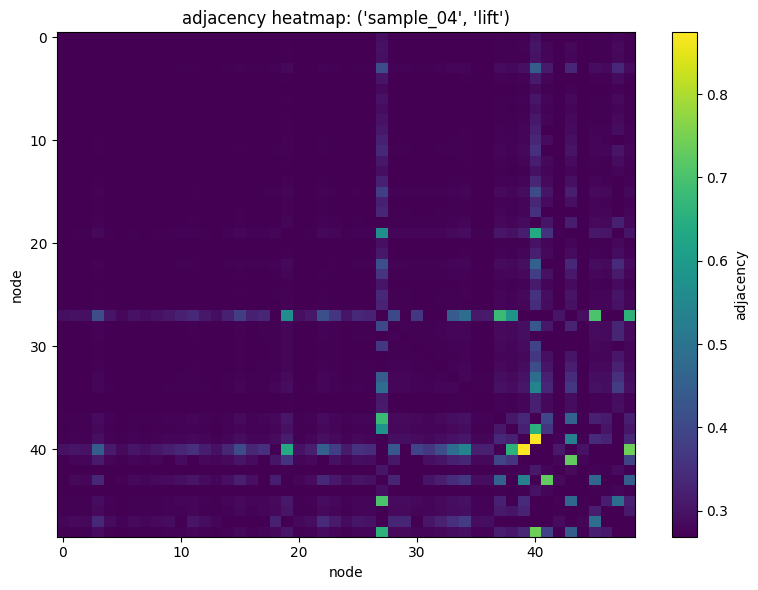

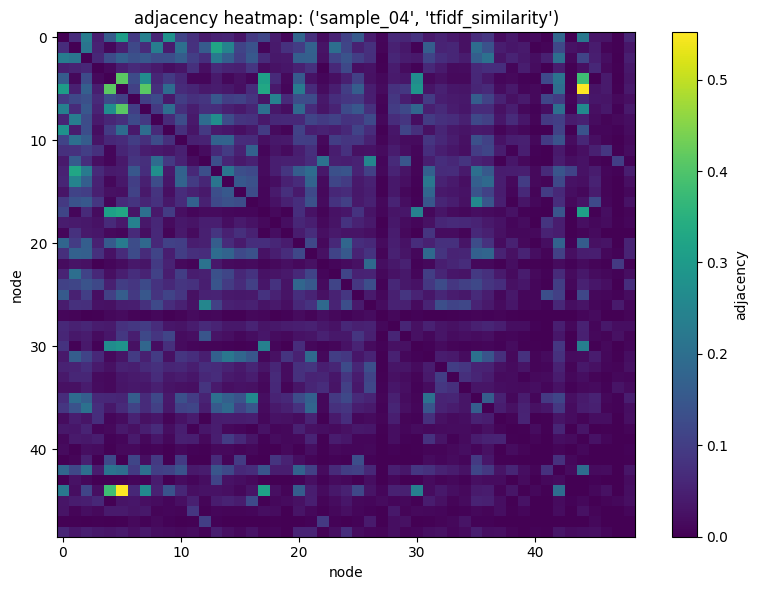

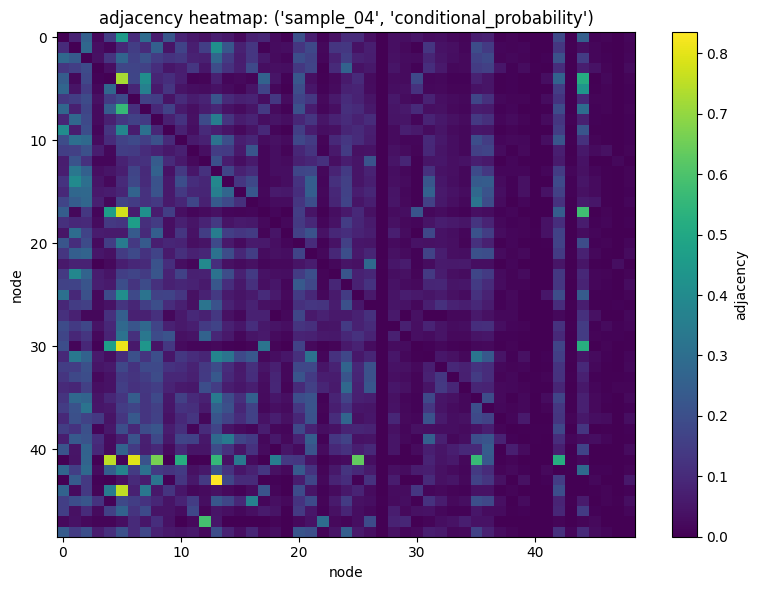

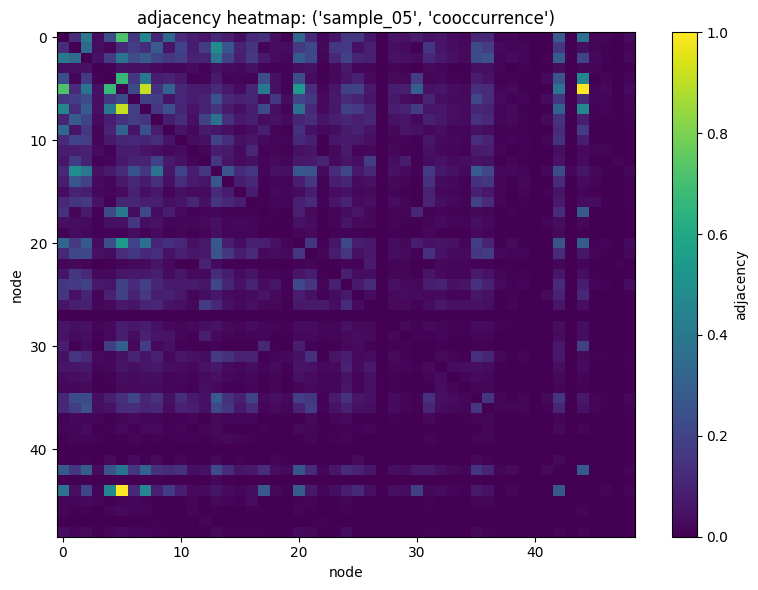

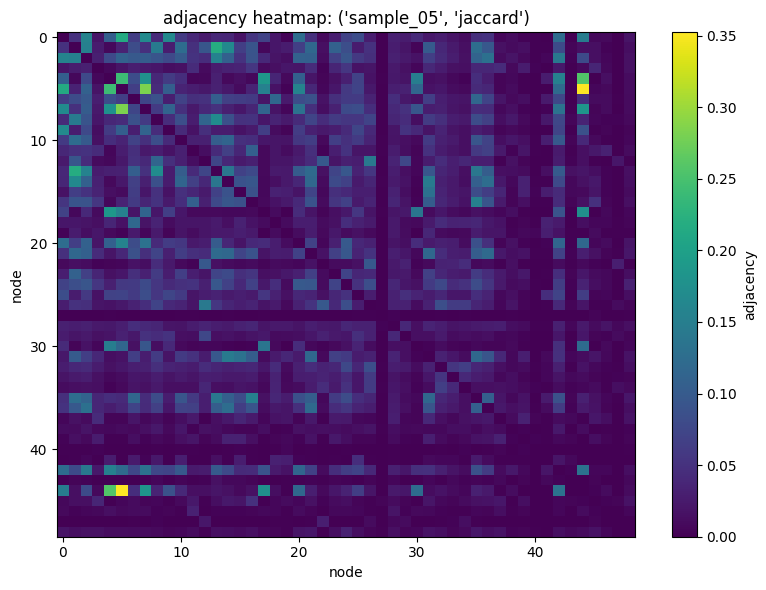

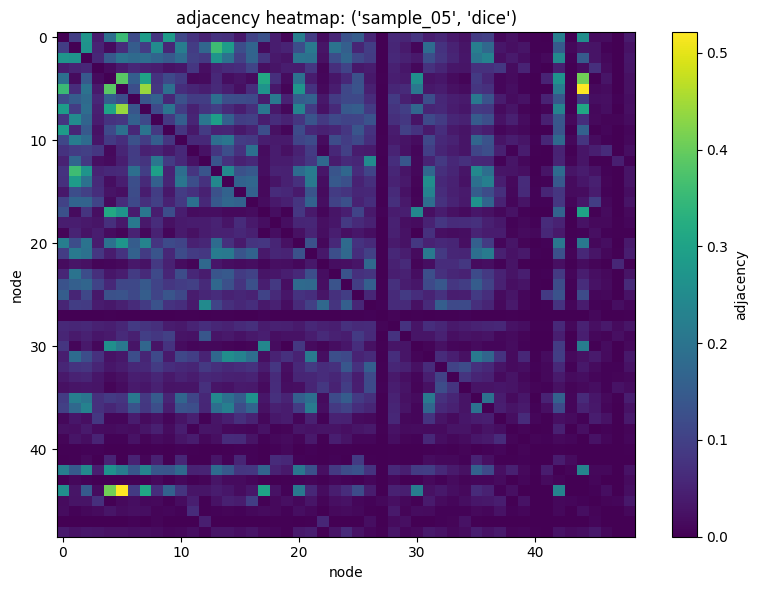

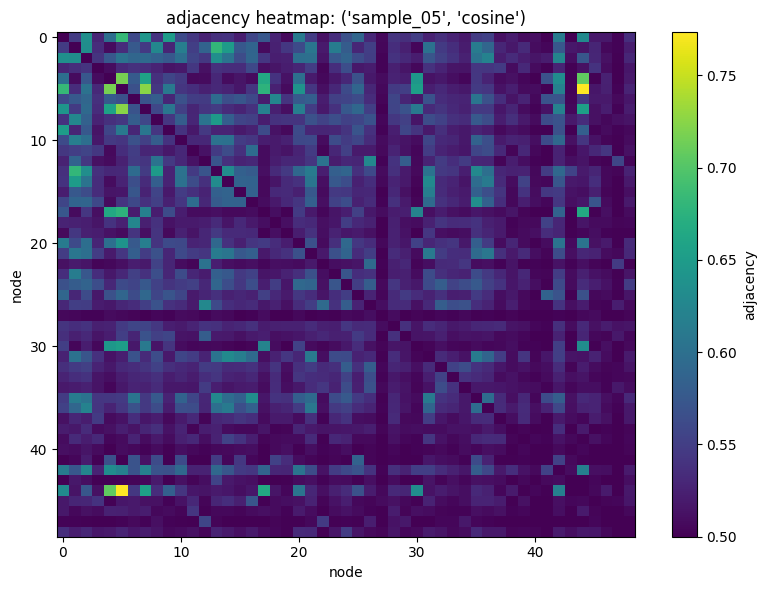

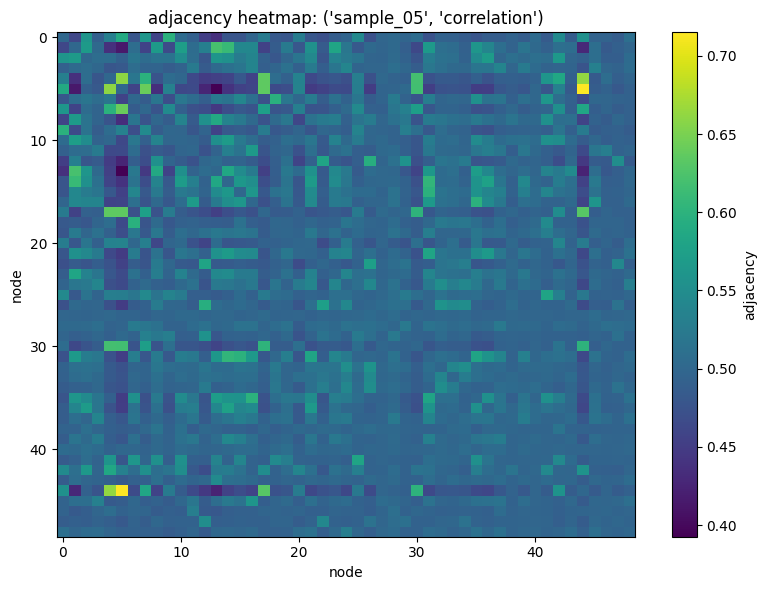

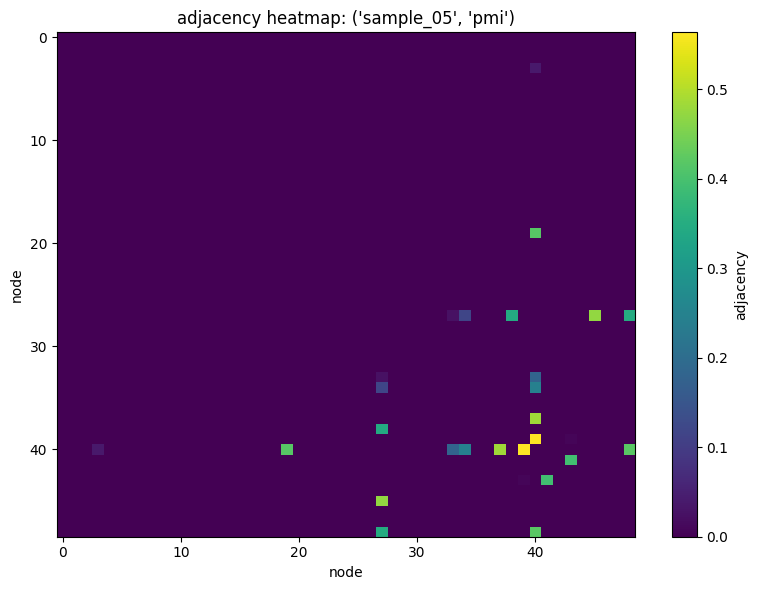

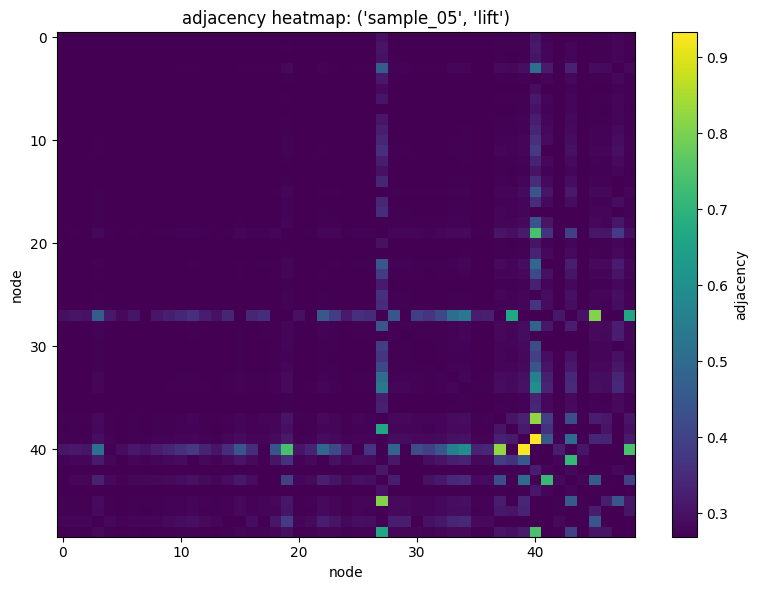

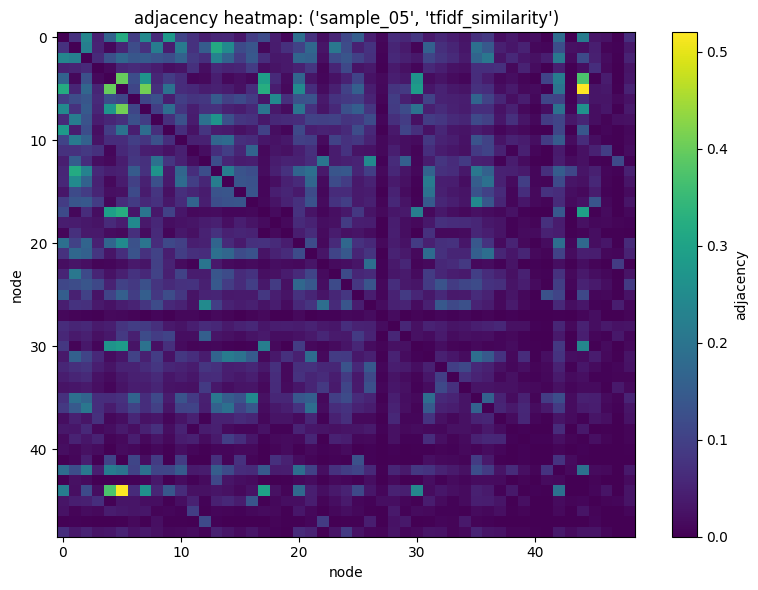

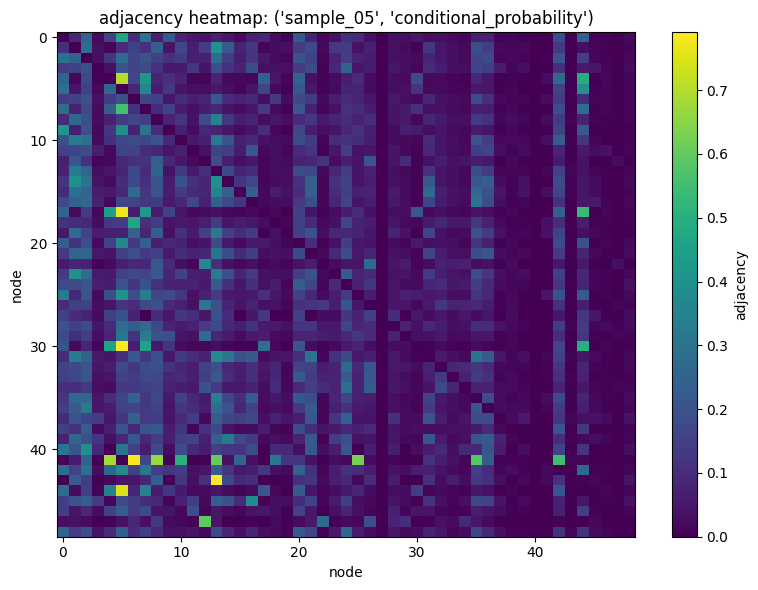

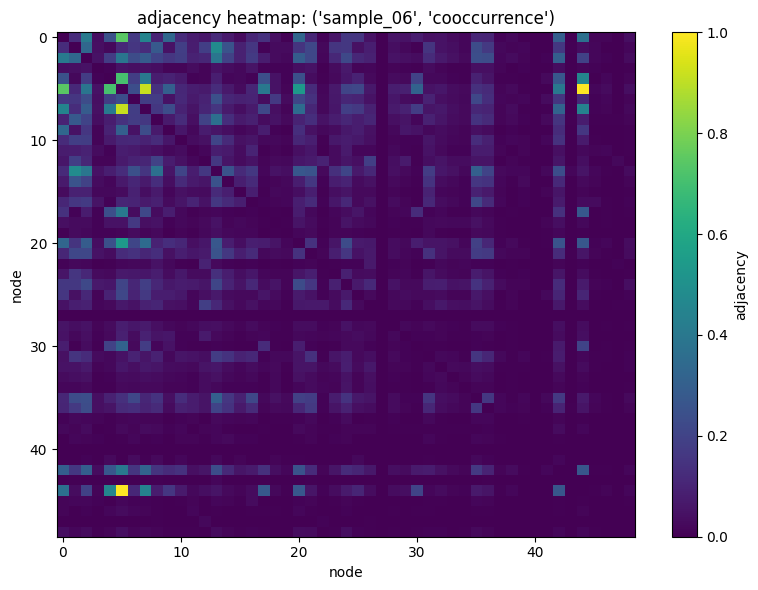

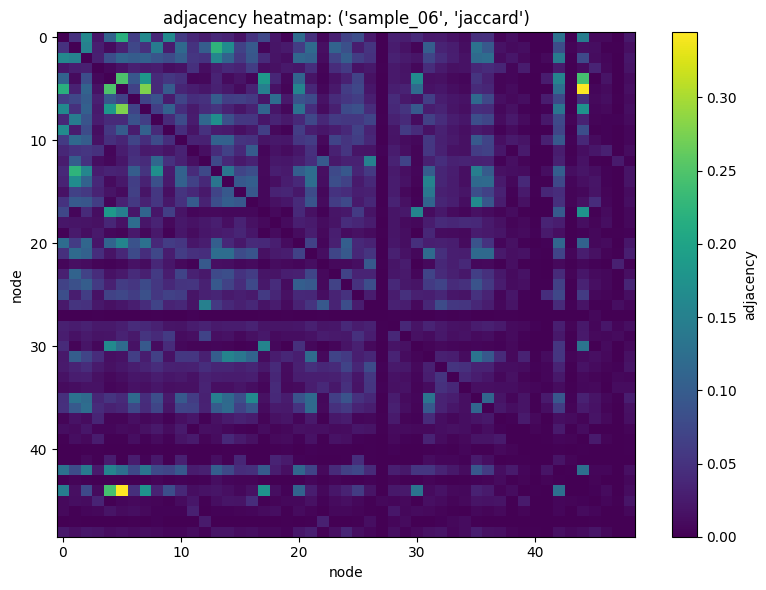

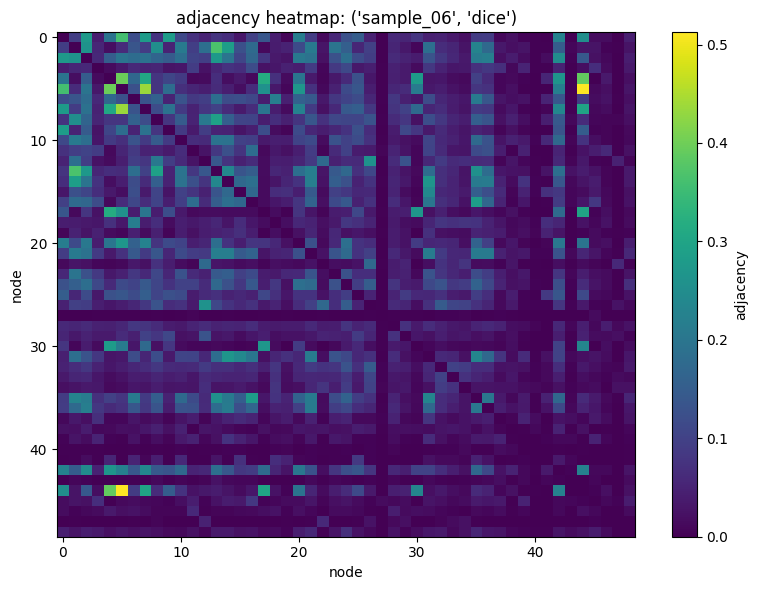

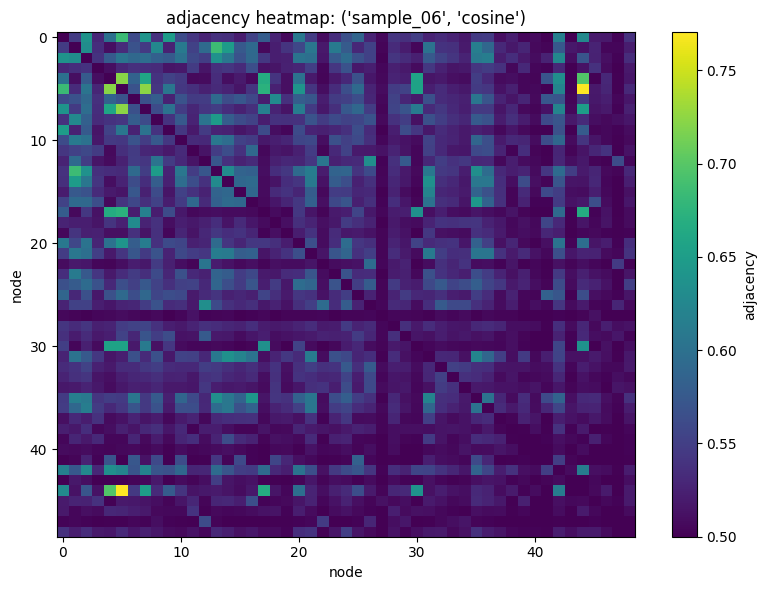

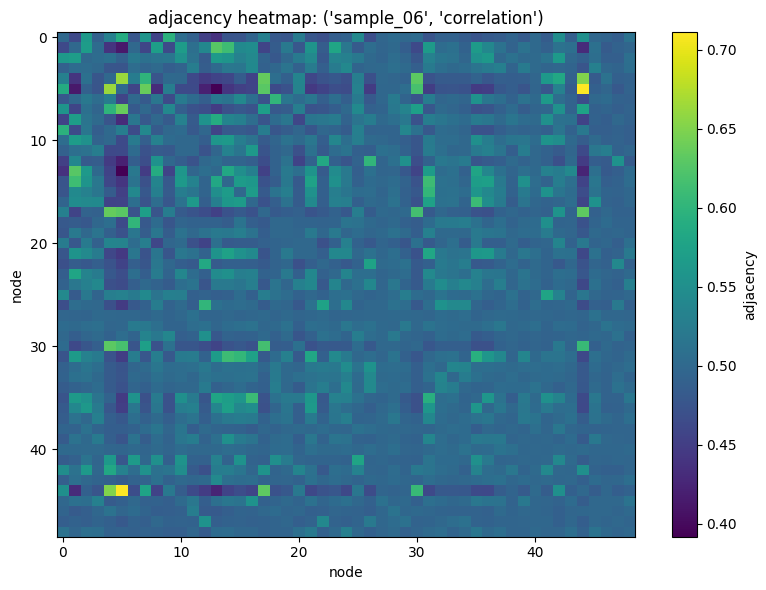

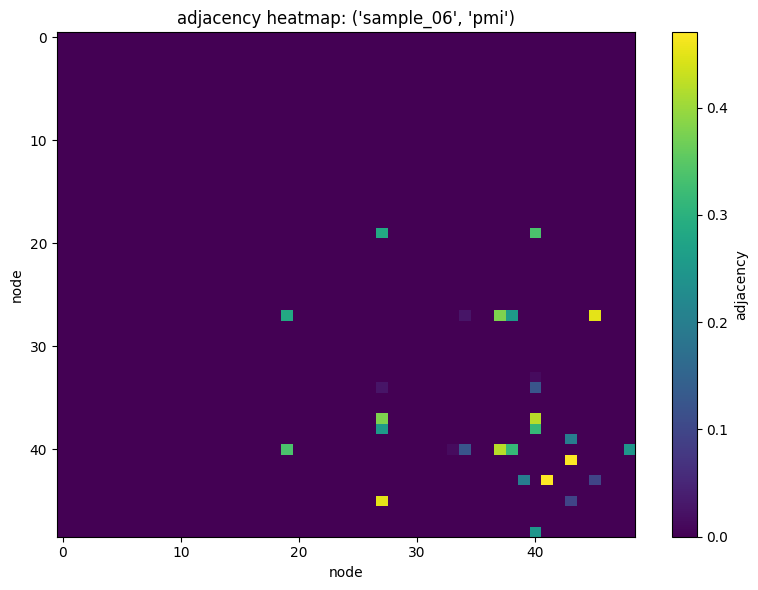

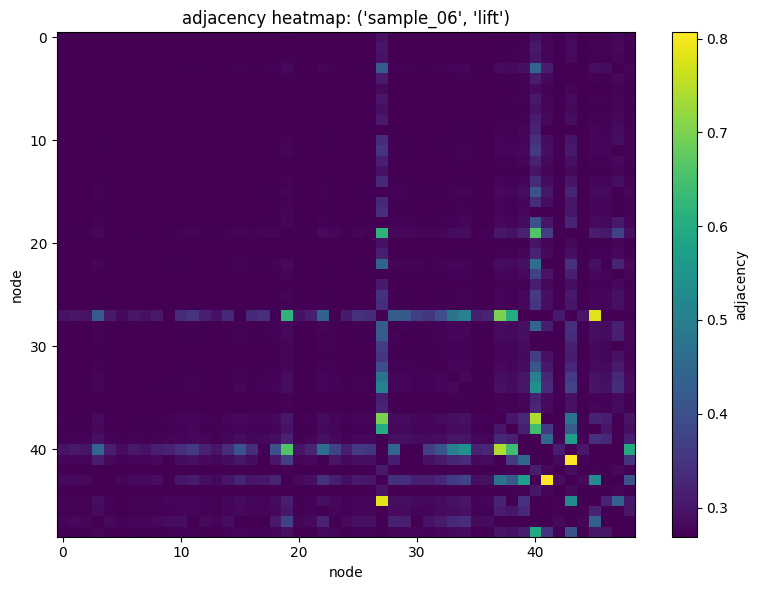

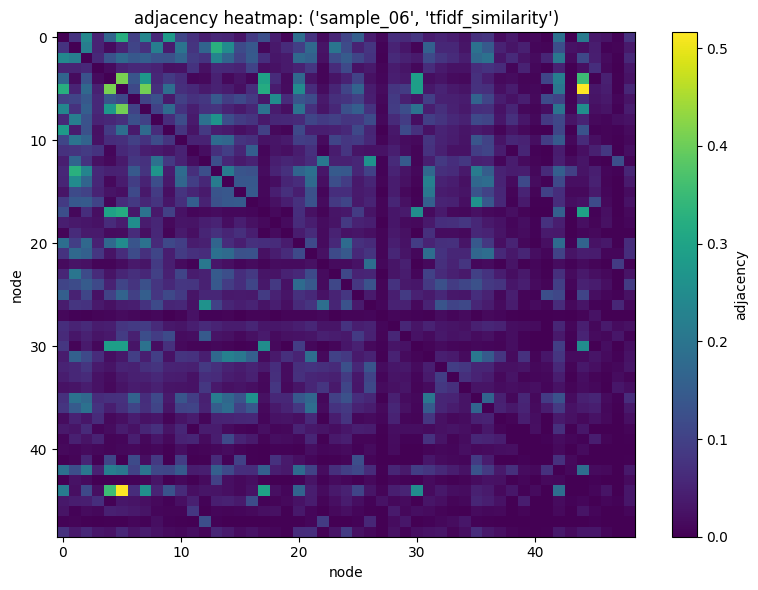

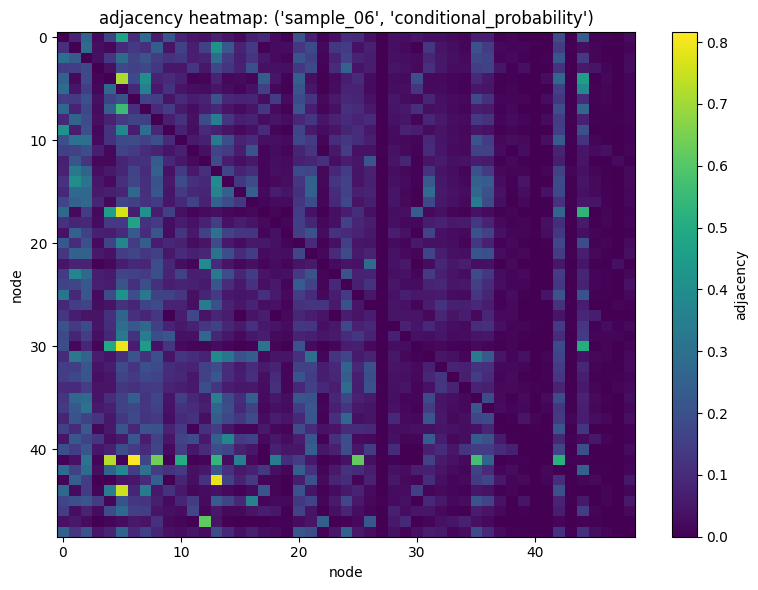

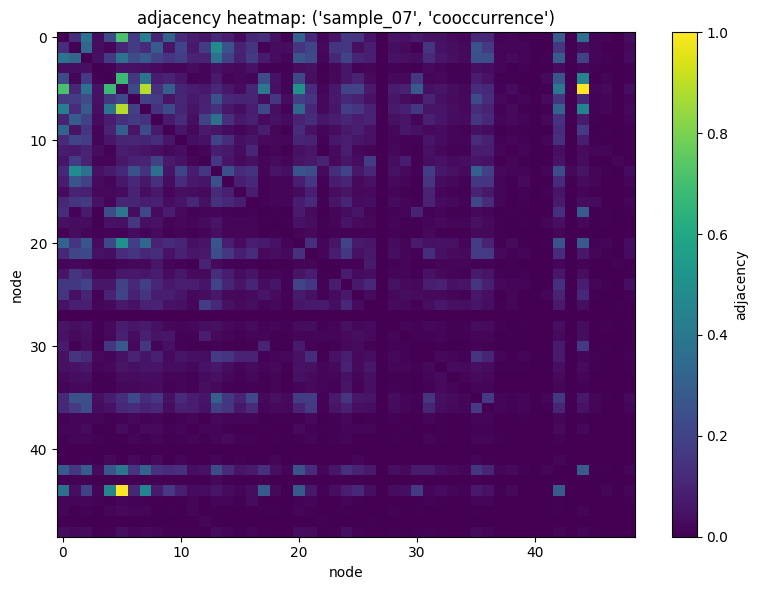

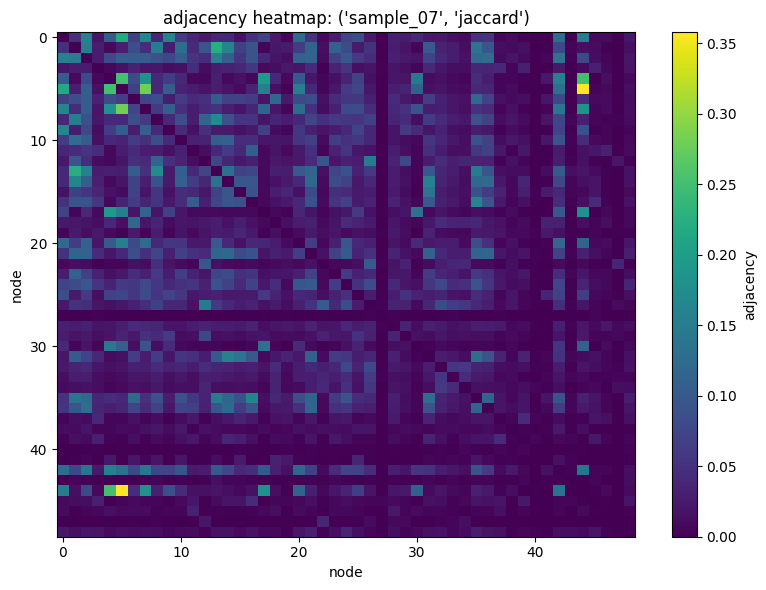

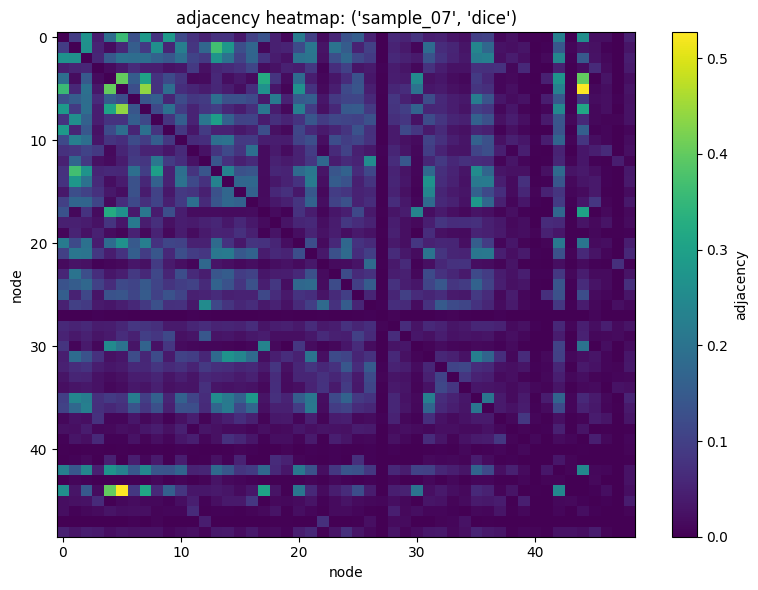

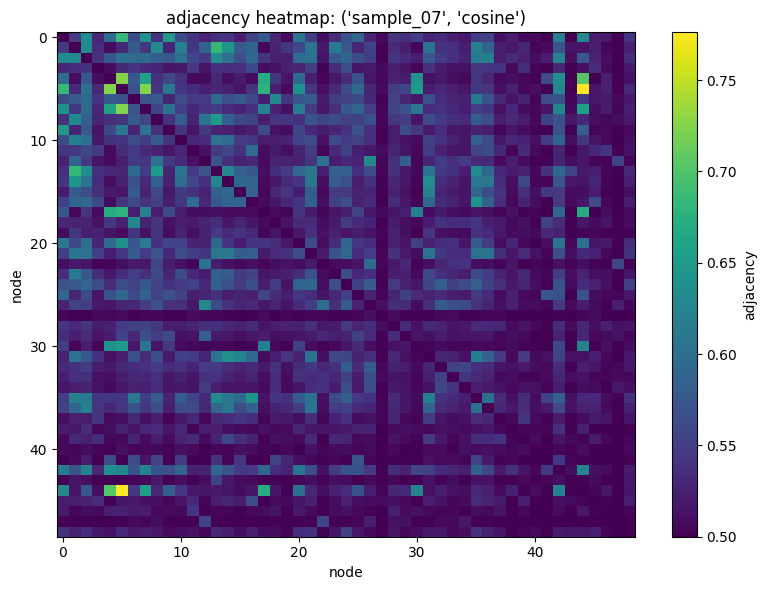

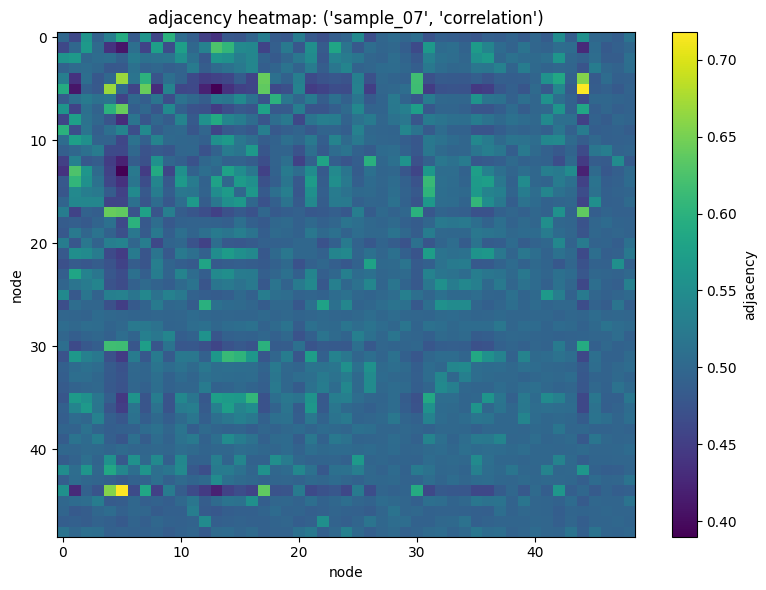

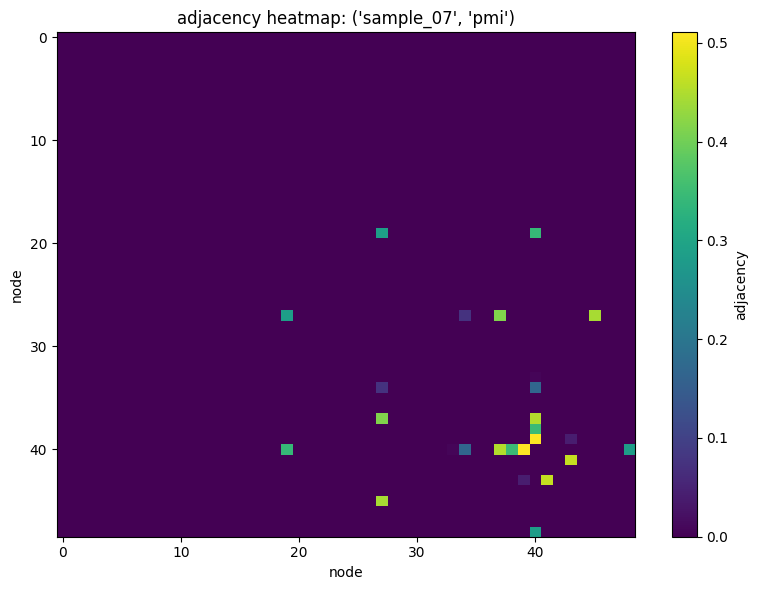

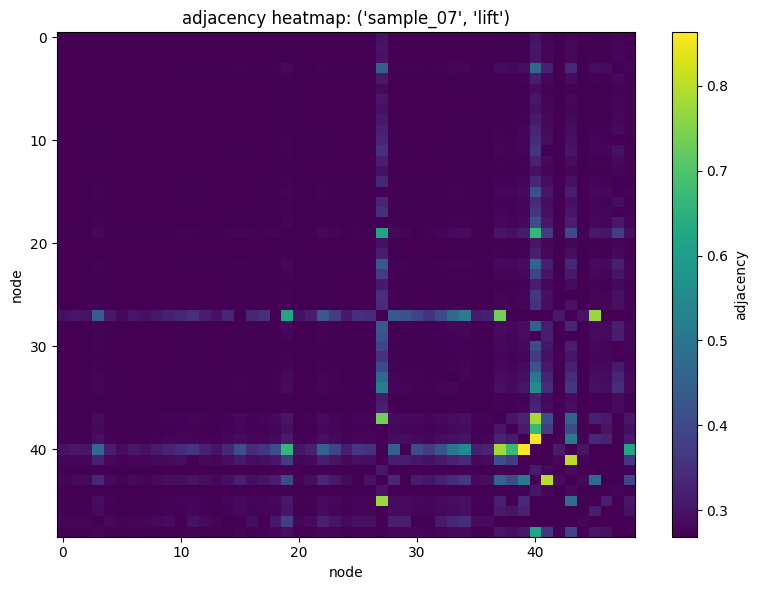

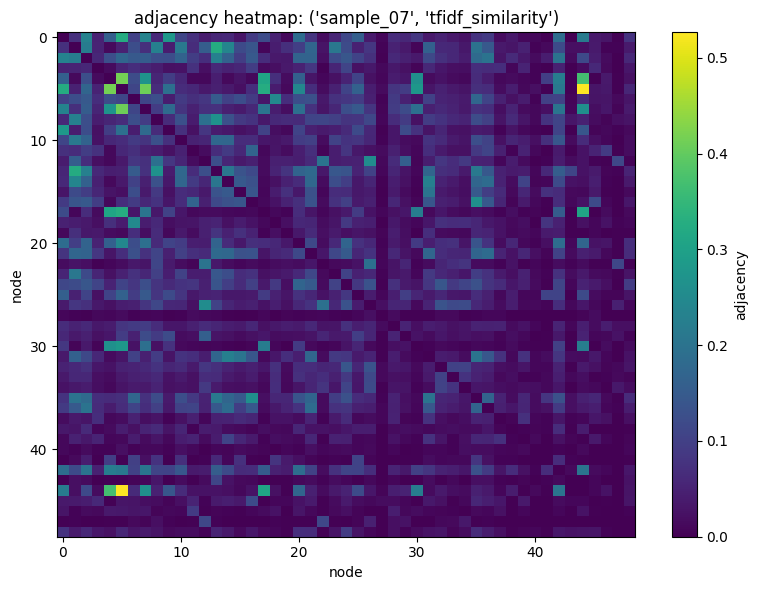

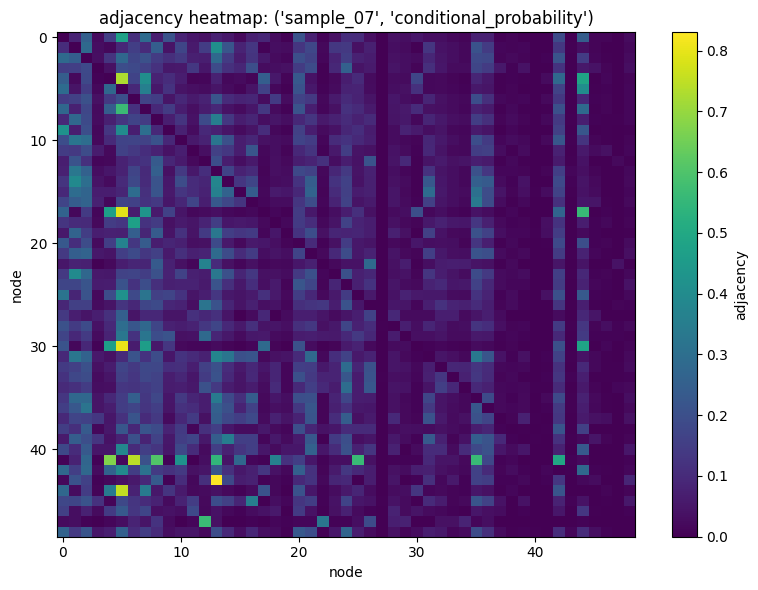

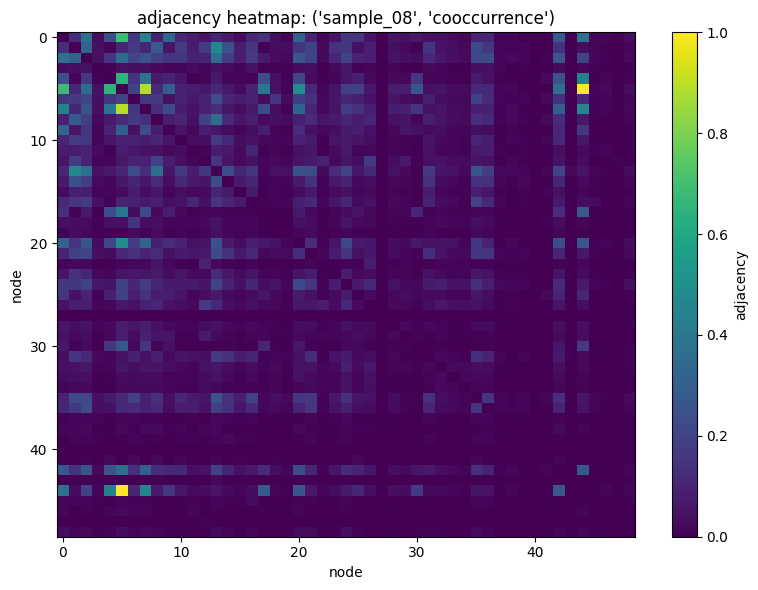

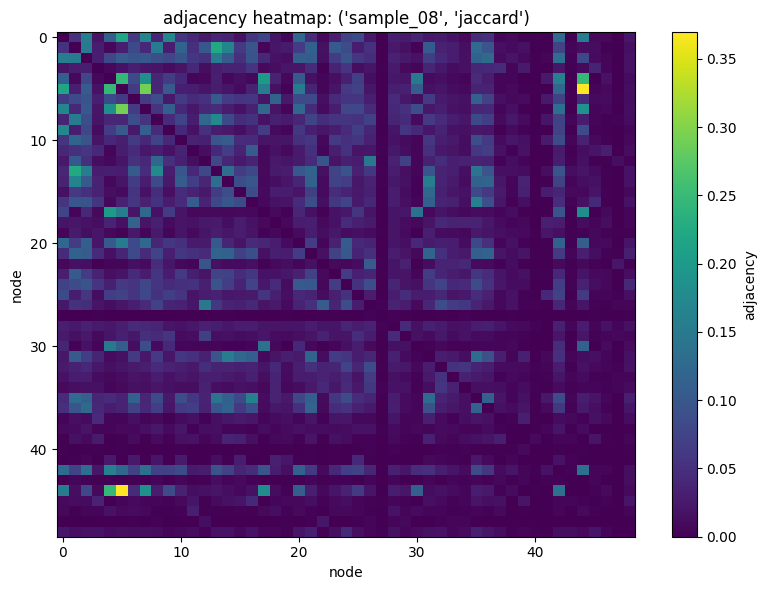

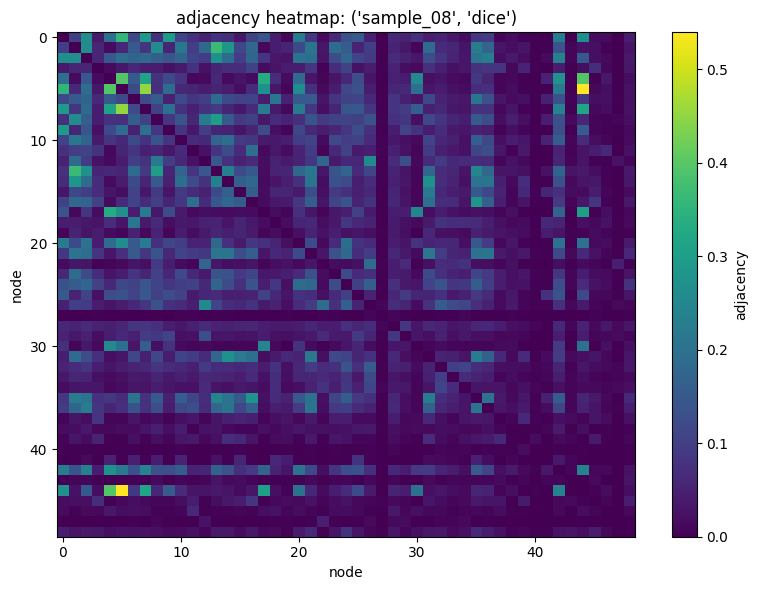

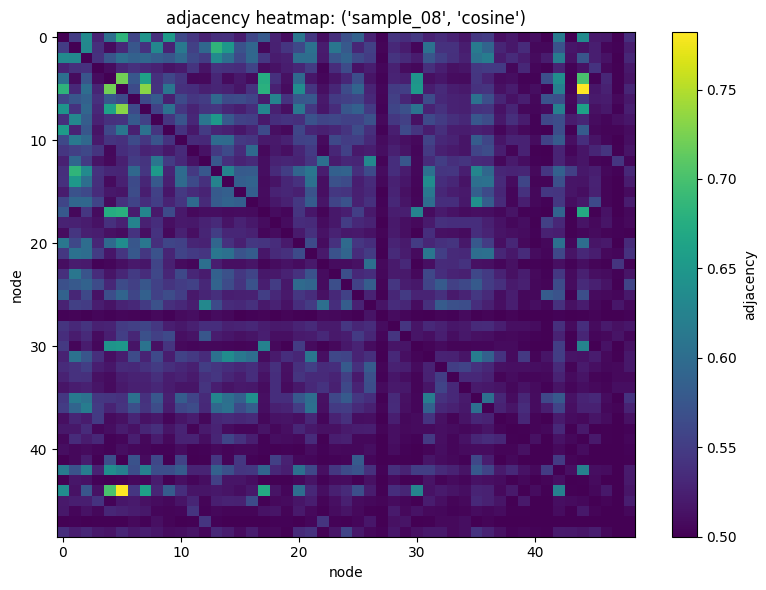

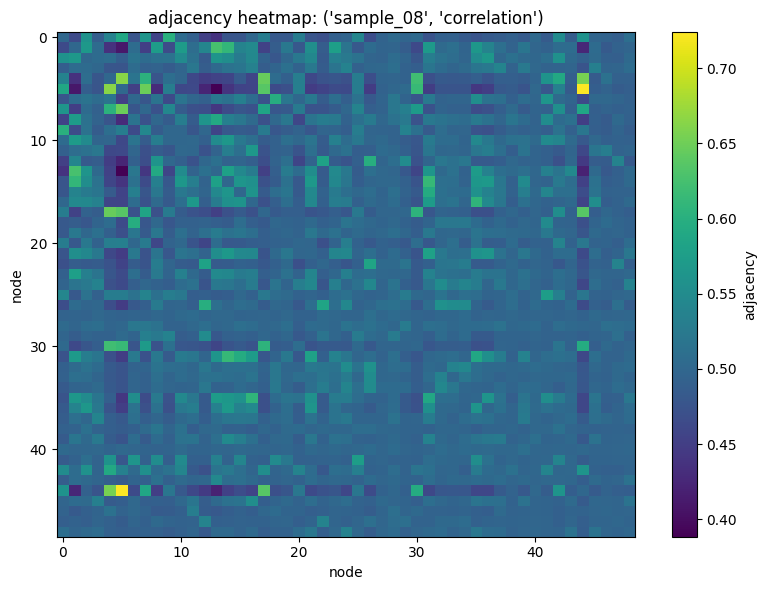

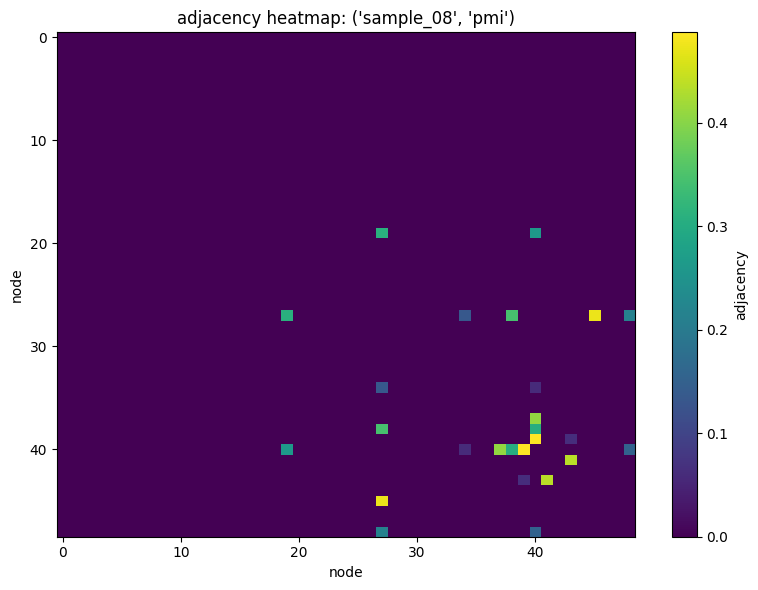

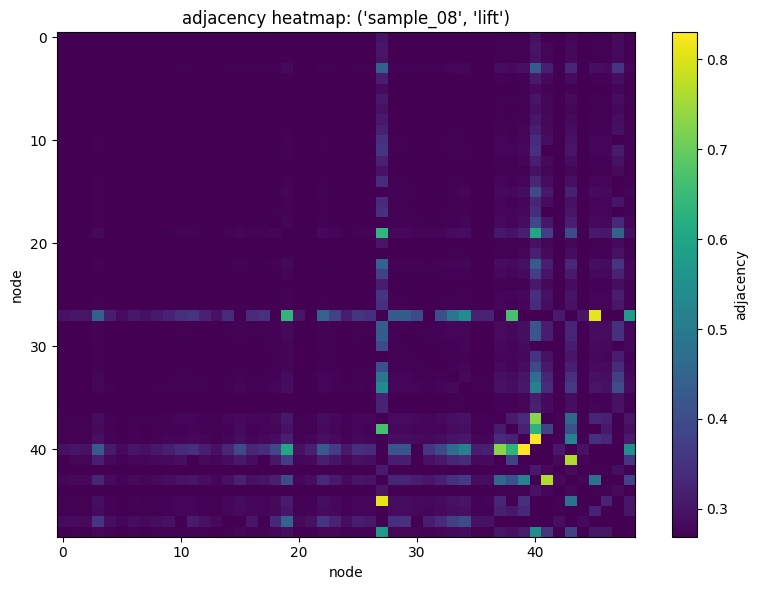

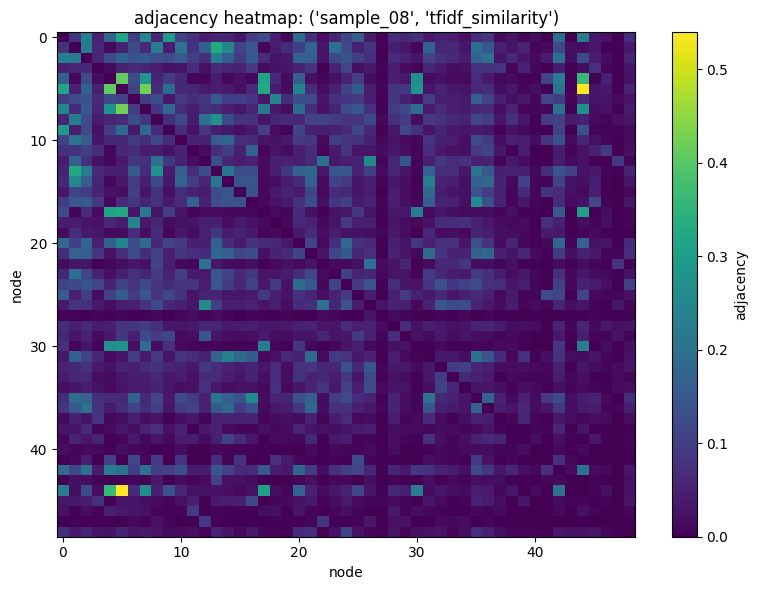

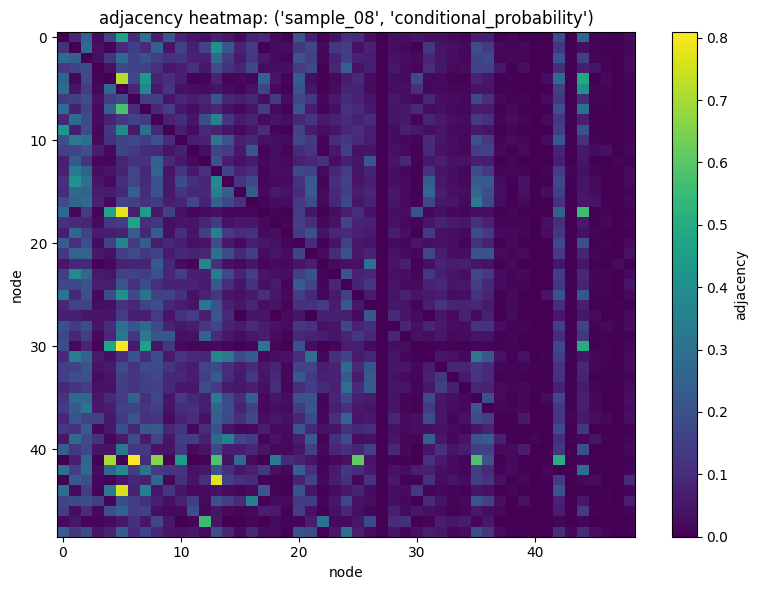

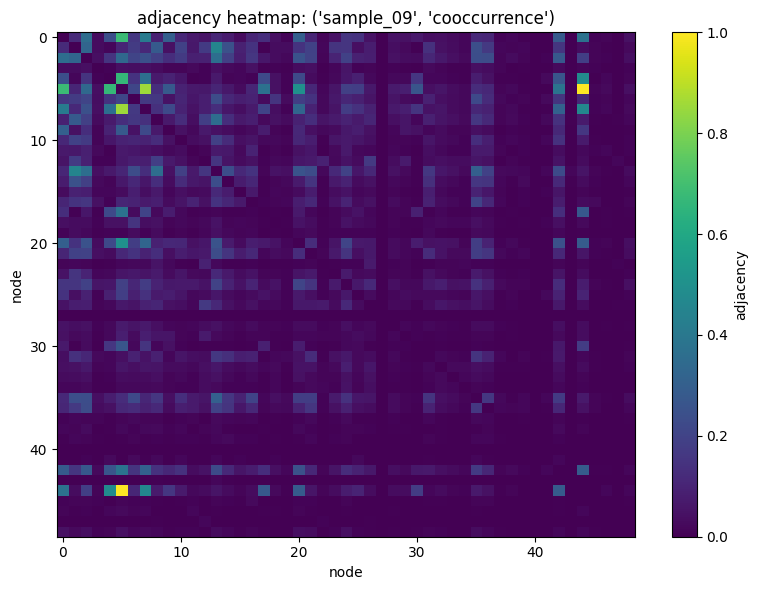

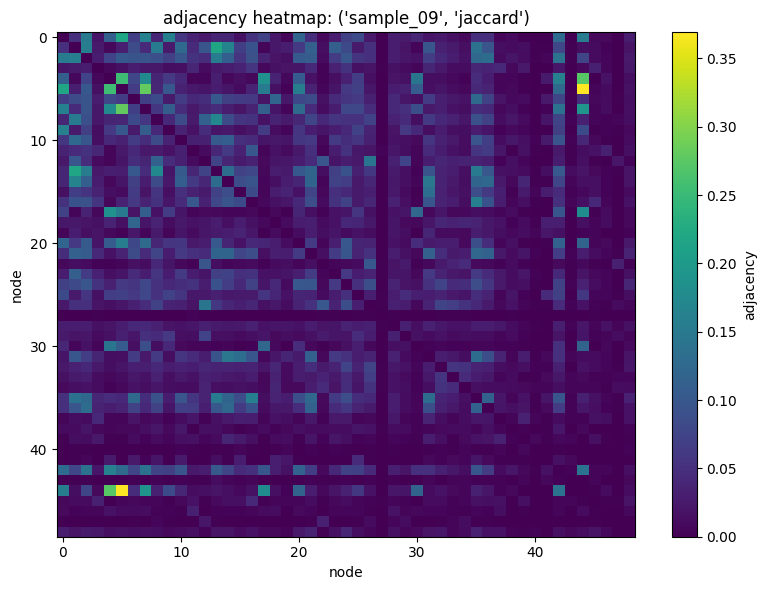

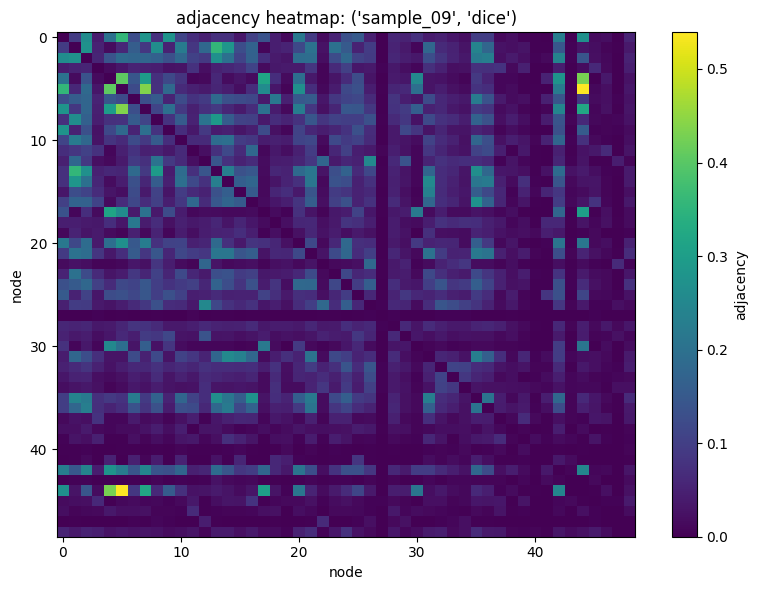

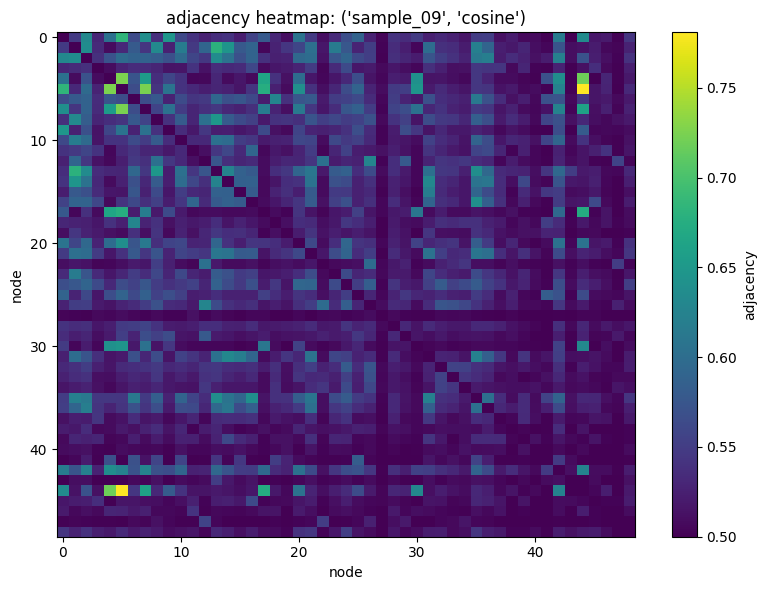

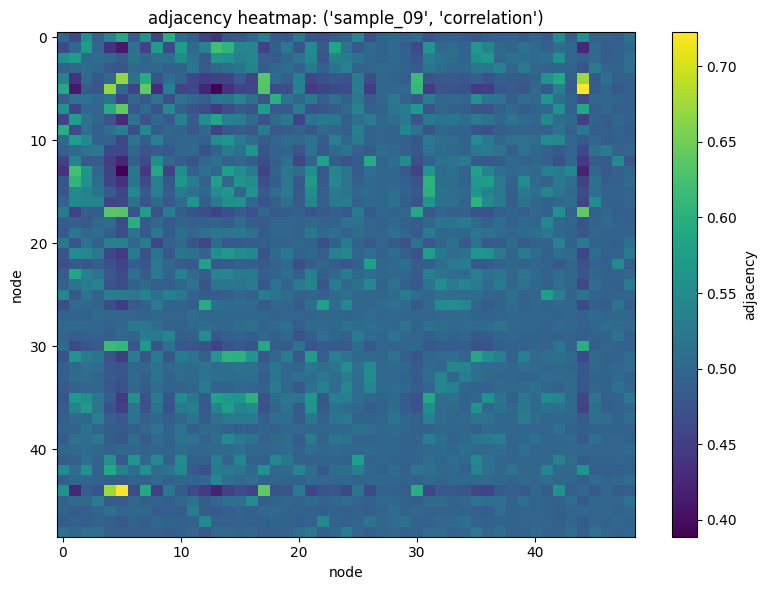

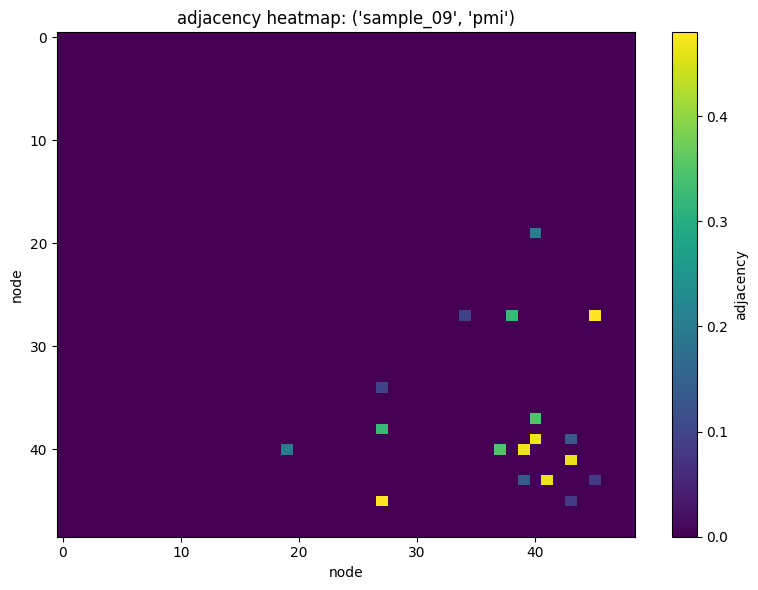

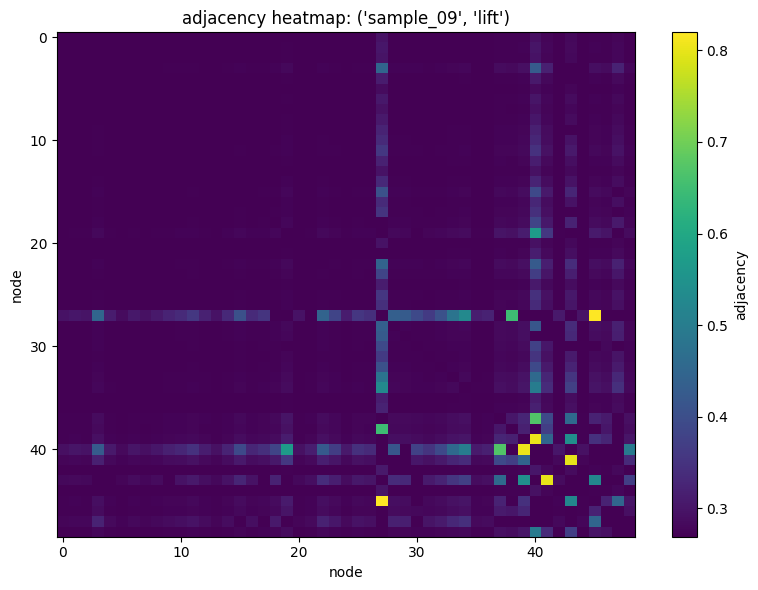

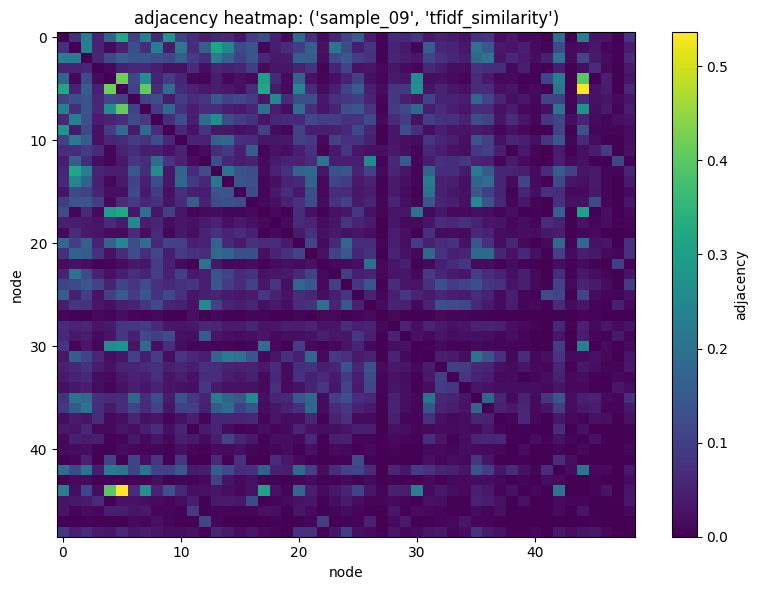

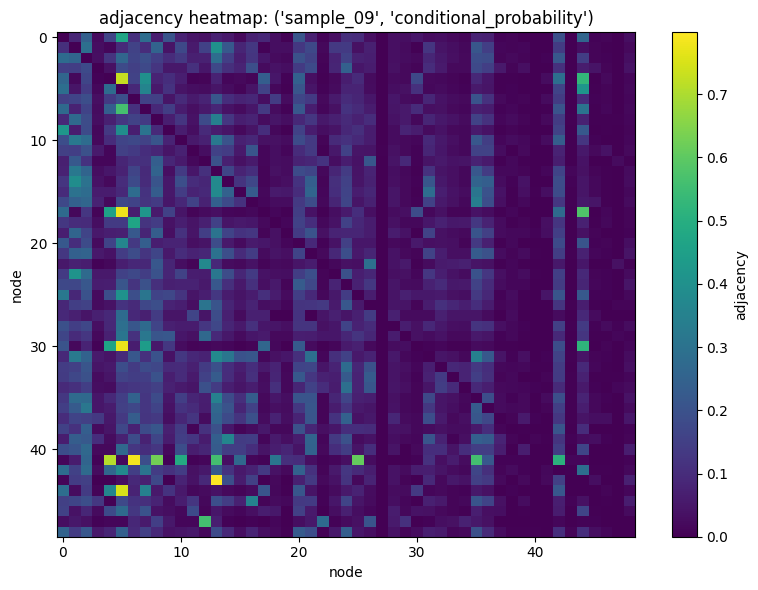

In [23]:
adj = analyzer.adjacencies
import matplotlib.pyplot as plt

# plot heatmap for each adjacency matrix
for key, mat in adj.items():
    plt.figure(figsize=(8, 6))
    plt.imshow(mat, aspect='auto')
    plt.colorbar(label='adjacency')
    plt.title(f'adjacency heatmap: {key}')
    plt.xlabel('node')
    plt.ylabel('node')
    plt.tight_layout()
    plt.show()
